In [37]:
#upload adult.data and adult.test
from google.colab import files
uploaded= files.upload()

Saving Adult_census_shap.csv to Adult_census_shap.csv


In [3]:
!pip install shap==0.23.1

     |████████████████████████████████| 184kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.23.1-cp36-cp36m-linux_x86_64.whl size=230188 sha256=ab57718e3ba74406ac30624b817413801afdaf48f37541fe050714e3017b74b6
  Stored in directory: /root/.cache/pip/wheels/d6/de/04/90cd2eab45f542feeff51aa672926157db2aa06ff07e879c5e
Successfully built shap


In [4]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style="darkgrid")
from time import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    

# Pretty display for notebooks
%matplotlib inline

In [5]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats  import entropy
from scipy.linalg import svd
from sklearn.decomposition import PCA, NMF
import sklearn
import numpy as np
from collections import namedtuple
import pandas as pd
from collections import Counter
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import cvxpy as cvx
import warnings
warnings.filterwarnings('ignore')
import pickle
from scipy.stats import wasserstein_distance

In [6]:
import shap

#Preprocessing the Dataset

In [79]:
#Add column names to the Dataset
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country', 'income']

#read in train data
adult_train = pd.read_csv('adult.data', header=None, names=columns, skipinitialspace=True)

#drop the fnlwgt column which is useless for later analysis
adult_train = adult_train.drop('fnlwgt', axis=1)

#Display several rows and shape of dataset
display(adult_train.head())
display(adult_train.shape)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


(32561, 14)

In [80]:
# Read in test data
adult_test = pd.read_csv('adult.test', header=None, skiprows=1, names=columns, skipinitialspace=True)

# Drop the fnlwgt column which is useless for later analysis
adult_test = adult_test.drop('fnlwgt', axis=1)

# Remove '.' in income column
adult_test['income'] = adult_test['income'].apply(lambda x: '>50K' if x=='>50K.' else '<=50K')

# Review several rows and shape of data set
display(adult_test.head())
display(adult_test.shape)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


(16281, 14)

In [81]:
#Examine if there are missing values
adult_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   education       32561 non-null  object
 3   education-num   32561 non-null  int64 
 4   marital-status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  income          32561 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


In [82]:
#Check missing value code and convert to NaNs
object_col = adult_train.select_dtypes(include=object).columns.tolist()
for col in object_col:
  print(adult_train[col].value_counts(dropna=False)/adult_train.shape[0], '\n')

Private             0.697030
Self-emp-not-inc    0.078038
Local-gov           0.064279
?                   0.056386
State-gov           0.039864
Self-emp-inc        0.034274
Federal-gov         0.029483
Without-pay         0.000430
Never-worked        0.000215
Name: workclass, dtype: float64 

HS-grad         0.322502
Some-college    0.223918
Bachelors       0.164461
Masters         0.052916
Assoc-voc       0.042443
11th            0.036086
Assoc-acdm      0.032769
10th            0.028654
7th-8th         0.019840
Prof-school     0.017690
9th             0.015786
12th            0.013298
Doctorate       0.012684
5th-6th         0.010227
1st-4th         0.005160
Preschool       0.001566
Name: education, dtype: float64 

Married-civ-spouse       0.459937
Never-married            0.328092
Divorced                 0.136452
Separated                0.031479
Widowed                  0.030497
Married-spouse-absent    0.012837
Married-AF-spouse        0.000706
Name: marital-status, dtype: floa

In [83]:
#Convert '?' to NaNs and remove the entries with NaN value
for col in object_col:
  adult_train.loc[adult_train[col]=='?', col] = np.nan
  adult_test.loc[adult_test[col]=='?', col] = np.nan

#perform a missing assessment in each column of the dataset
col_missing_pct = adult_train.isna().sum()/adult_train.shape[0]
col_missing_pct.sort_values(ascending=False)

occupation        0.056601
workclass         0.056386
native-country    0.017905
income            0.000000
hours-per-week    0.000000
capital-loss      0.000000
capital-gain      0.000000
sex               0.000000
race              0.000000
relationship      0.000000
marital-status    0.000000
education-num     0.000000
education         0.000000
age               0.000000
dtype: float64

In [84]:
#Remove data entries with missing value
adult_train = adult_train.dropna(axis=0, how='any')
adult_test = adult_test.dropna(axis=0, how='any')

#Show the results of the split
print("After removing the missing value:")
print("Training set has {} samples.".format(adult_train.shape[0]))
print("Test set has {} samples.".format(adult_test.shape[0]))

After removing the missing value:
Training set has 30162 samples.
Test set has 15060 samples.


#Data analysis

In [85]:
# Combine the data
adult_data = pd.concat([adult_train, adult_test])

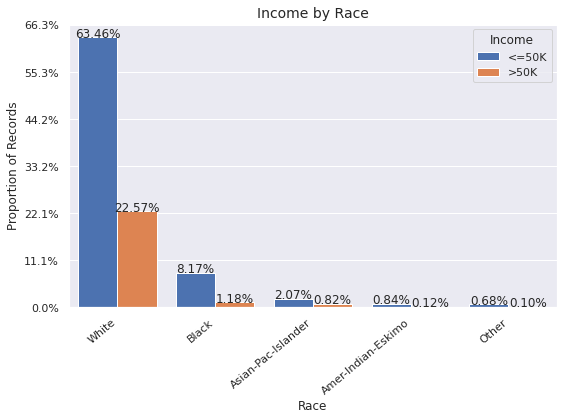

In [86]:
# Use occupation percentage of '>50K' as order of the plot
order = (adult_data.race[adult_data.income=='>50K'].value_counts()/adult_data.shape[0]).index

# Plotting the income by age
plt.figure(figsize=(8,6))
ax = sns.countplot(x = 'race', hue = 'income', order = order, data = adult_data, saturation=1)
ax.set_title('Income by Race', fontsize = 14)
ax.set_xlabel("Race")
ax.set_ylabel("Proportion of Records")

# new_ticks = [i.get_text() for i in ax.get_xticklabels()]
# plt.xticks(range(0, len(new_ticks), 10), new_ticks[::10])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = adult_data.shape[0]*1.
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
ax.legend(loc=1, title='Income')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100.0),
            ha="center") 
    
plt.tight_layout()
plt.show()



In [87]:
# Total number of records
n_records = adult_data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = np.sum(adult_data.income=='>50K')

# Number of records where individual's incomre is less than $50,000
n_at_most_50k = np.sum(adult_data.income=='<=50K')

# Percentage of indiciduals whose income is more than $50,000
greater_percentage = round(np.mean(adult_data.income=='>50K')*100.00, 2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percentage))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


Transforming Skewed Continuous Features

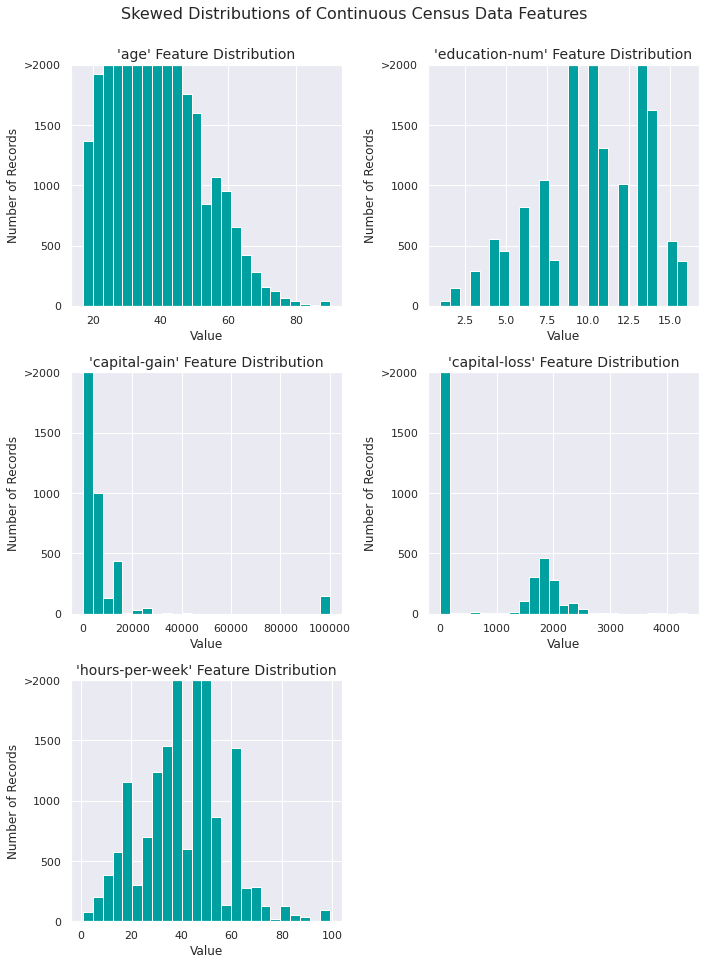

In [88]:
# Check the skewness of numerical variables in data set
num_col = adult_train.dtypes[adult_train.dtypes != 'object'].index

# Create figure
fig = plt.figure(figsize = (10,13));

# Skewed feature plotting
for i, feature in enumerate(adult_train[num_col]):
    ax = fig.add_subplot(3, 2, i+1)
    ax.hist(adult_train[feature], bins = 25, color = '#00A0A0')
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 2000))
    ax.set_yticks([0, 500, 1000, 1500, 2000])
    ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

# Plot aesthetics
fig.suptitle("Skewed Distributions of Continuous Census Data Features", fontsize = 16, y = 1.03)

fig.tight_layout()
fig.show()

In [89]:
# Calculate skew and sort
skew_feats = adult_train[num_col].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skew_feats})
skewness

,Skew
capital-gain,11.902682
capital-loss,4.526380
age,0.530228
hours-per-week,0.330869
education-num,-0.305379


In [90]:
# Split the data into features and target label
income_raw = adult_train['income']
feature_raw = adult_train.drop('income', axis=1)

income_raw_test = adult_test['income']
feature_raw_test = adult_test.drop('income', axis=1)

# Log transform the skewed feature highly-skewed feature 'capital-gain' and 'capital-loss'. 
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data=feature_raw)
features_log_transformed[skewed] = feature_raw[skewed].apply(lambda x: np.log(x + 1))

features_log_transformed_test = pd.DataFrame(data=feature_raw_test)
features_log_transformed_test[skewed] = feature_raw_test[skewed].apply(lambda x: np.log(x + 1))

Normalizing Numerical Features

In [91]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[num_col] = scaler.fit_transform(features_log_transformed[num_col])

# Transform the test data set
features_log_minmax_transform_test = pd.DataFrame(data = features_log_transformed_test)
features_log_minmax_transform_test[num_col] = scaler.transform(features_log_transformed_test[num_col])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head())
display(features_log_minmax_transform_test.head())

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.109589,Private,11th,0.400000,Never-married,Machine-op-inspct,Own-child,Black,Male,0.000000,0.0,0.397959,United-States
1,0.287671,Private,HS-grad,0.533333,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.000000,0.0,0.500000,United-States
2,0.150685,Local-gov,Assoc-acdm,0.733333,Married-civ-spouse,Protective-serv,Husband,White,Male,0.000000,0.0,0.397959,United-States
3,0.369863,Private,Some-college,0.600000,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,0.777174,0.0,0.397959,United-States
5,0.232877,Private,10th,0.333333,Never-married,Other-service,Not-in-family,White,Male,0.000000,0.0,0.295918,United-States


Data preprocessing

In [92]:
# One-hot encode the 'features_log_minmax_transform' data using sklearn.OneHotEncoder

# Categorical columns' names
cat_feats = features_log_minmax_transform.dtypes[features_log_minmax_transform.dtypes=='object'].index.tolist()
cat_idx = [features_log_minmax_transform.columns.get_loc(col) for col in cat_feats]

# Create the encoder.
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Fit and transform the encoder on categorical features
encoded_cat_feats = encoder.fit_transform(features_log_minmax_transform.loc[:,cat_feats])

# Extract one-hot-encoder's feature names
cat_col_name = features_log_minmax_transform.columns.to_numpy()[cat_idx].tolist()
encoded_cat_feats_name = encoder.get_feature_names(cat_col_name)

# Generate OHE dataframe and concatenate it with the numerical dataframe later
encoded_cat_feats_df = pd.DataFrame(encoded_cat_feats, columns=encoded_cat_feats_name)
encoded_cat_feats_df.head()

,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,...,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
# Apply OHE above to transform the test dataset
encoded_cat_feats_test = encoder.transform(features_log_minmax_transform_test.loc[:,cat_feats])

# Generate OHE dataframe and concatenate it with the numerical dataframe later
encoded_cat_feats_df_test = pd.DataFrame(encoded_cat_feats_test, columns=encoded_cat_feats_name)
encoded_cat_feats_df_test.head()

,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,...,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [94]:
# Extract the dataframe with only numerical features
num_feats_df = features_log_minmax_transform[num_col].reset_index()

# Concatenate numerical and encoded categorical features together
X_train = pd.merge(num_feats_df, encoded_cat_feats_df, left_index=True, right_index=True).drop('index', axis=1)

# Encode the 'income_raw' to numerical values
y_train = income_raw.apply(lambda x: 1 if x == '>50K' else 0)

print("{} total features after one-hot encoding.".format(len(X_train.columns)))

# Display several rows of processed dataframe
X_train.head()

103 total features after one-hot encoding.


,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,...,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.301370,0.800000,0.667492,0.0,0.397959,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.452055,0.800000,0.000000,0.0,0.122449,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.287671,0.533333,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.493151,0.400000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.150685,0.800000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
# Do the same transformation on test data
# Extract the dataframe with only numerical features
num_feats_df_test = features_log_minmax_transform_test[num_col].reset_index()

# Concatenate numerical and encoded categorical features together
X_test = pd.merge(num_feats_df_test, encoded_cat_feats_df_test, left_index=True, right_index=True)\
            .drop('index', axis=1)

# Encode the 'income_raw' to numerical values
y_test = income_raw_test.apply(lambda x: 1 if x == '>50K' else 0)

print("{} total features after one-hot encoding.".format(len(X_test.columns)))

# Display several rows of processed dataframe
X_test.head()

103 total features after one-hot encoding.


,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,...,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.109589,0.400000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.287671,0.533333,0.000000,0.0,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.150685,0.733333,0.000000,0.0,0.397959,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.369863,0.600000,0.777174,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.232877,0.333333,0.000000,0.0,0.295918,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [96]:
# Combine the data
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [97]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(y.shape)
print(y_train.shape)
print(y_test.shape)

(45222, 103)
(30162, 103)
(15060, 103)
(45222,)
(30162,)
(15060,)


#Training Model

In [26]:
xgb_full = xgboost.DMatrix(X, label=y)
xgb_train =  xgboost.DMatrix(X_train, label = y_train)
xgb_test = xgboost.DMatrix(X_test, label = y_test)

params = {
"eta": 0.002,
"max_depth": 4,
"objective": 'binary:logistic',
"eval_metric":"auc",
"subsample": 0.5
}
model = xgboost.train(params, xgb_train, 5000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params,xgb_train, nfold = 3, metrics="auc" , num_boost_round=10)

[0]	test-auc:0.863243
[1000]	test-auc:0.907771
[2000]	test-auc:0.914339
[3000]	test-auc:0.918041
[4000]	test-auc:0.920839
[4999]	test-auc:0.922567


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.868160,0.002565,0.864637,0.002959
1,0.879972,0.003960,0.876734,0.005960
2,0.884257,0.001145,0.881132,0.004132
3,0.885778,0.001065,0.883048,0.005254
4,0.886094,0.001285,0.883356,0.005385
5,0.886540,0.000522,0.883944,0.004811
6,0.886616,0.001090,0.884187,0.005295
7,0.888371,0.002130,0.886018,0.003859
8,0.891068,0.001694,0.889036,0.005292
9,0.891003,0.001612,0.889065,0.005168


In [98]:
pred = model.predict(xgb_full)

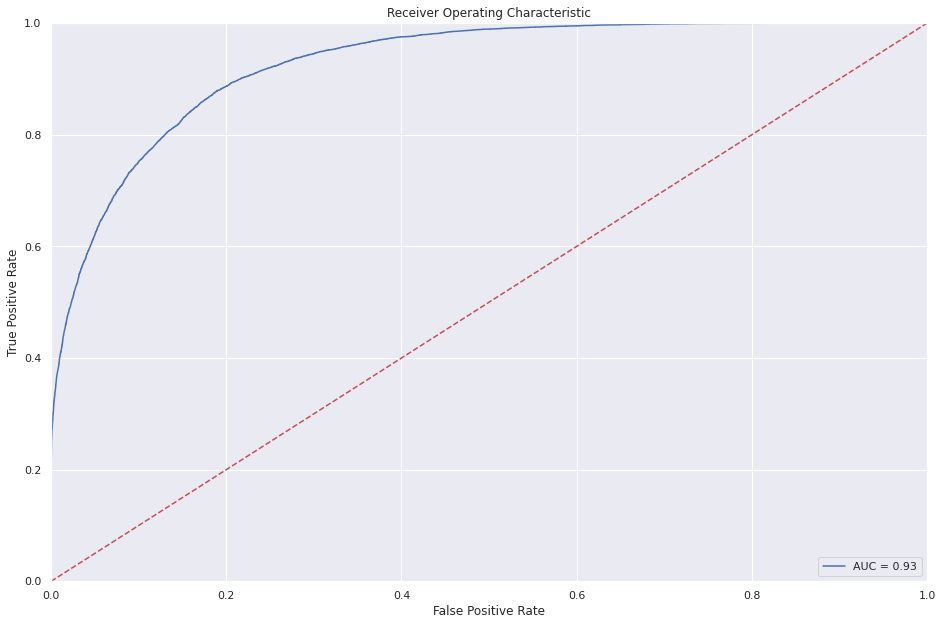

Optimal Threshold obtained using difference of TPR and FPR 0.24972734


In [99]:
fpr, tpr , thresholds = roc_curve(y, pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
y_pred = np.where(pred > optimal_threshold, 1, 0)

Calculte shap scores

In [100]:
independent_columns = list(X)
background = sklearn.utils.resample(X, n_samples=100, replace=True)
explainer = shap.TreeExplainer(model, feature_dependence='independent', model_output='probability')
shap_values =  explainer.shap_values(X)
shap_df1 = pd.DataFrame(shap_values, columns=independent_columns)
#shap_df1.to_csv(shap_file_name, index = False)
print(shap_values.shape)

(45222, 103)


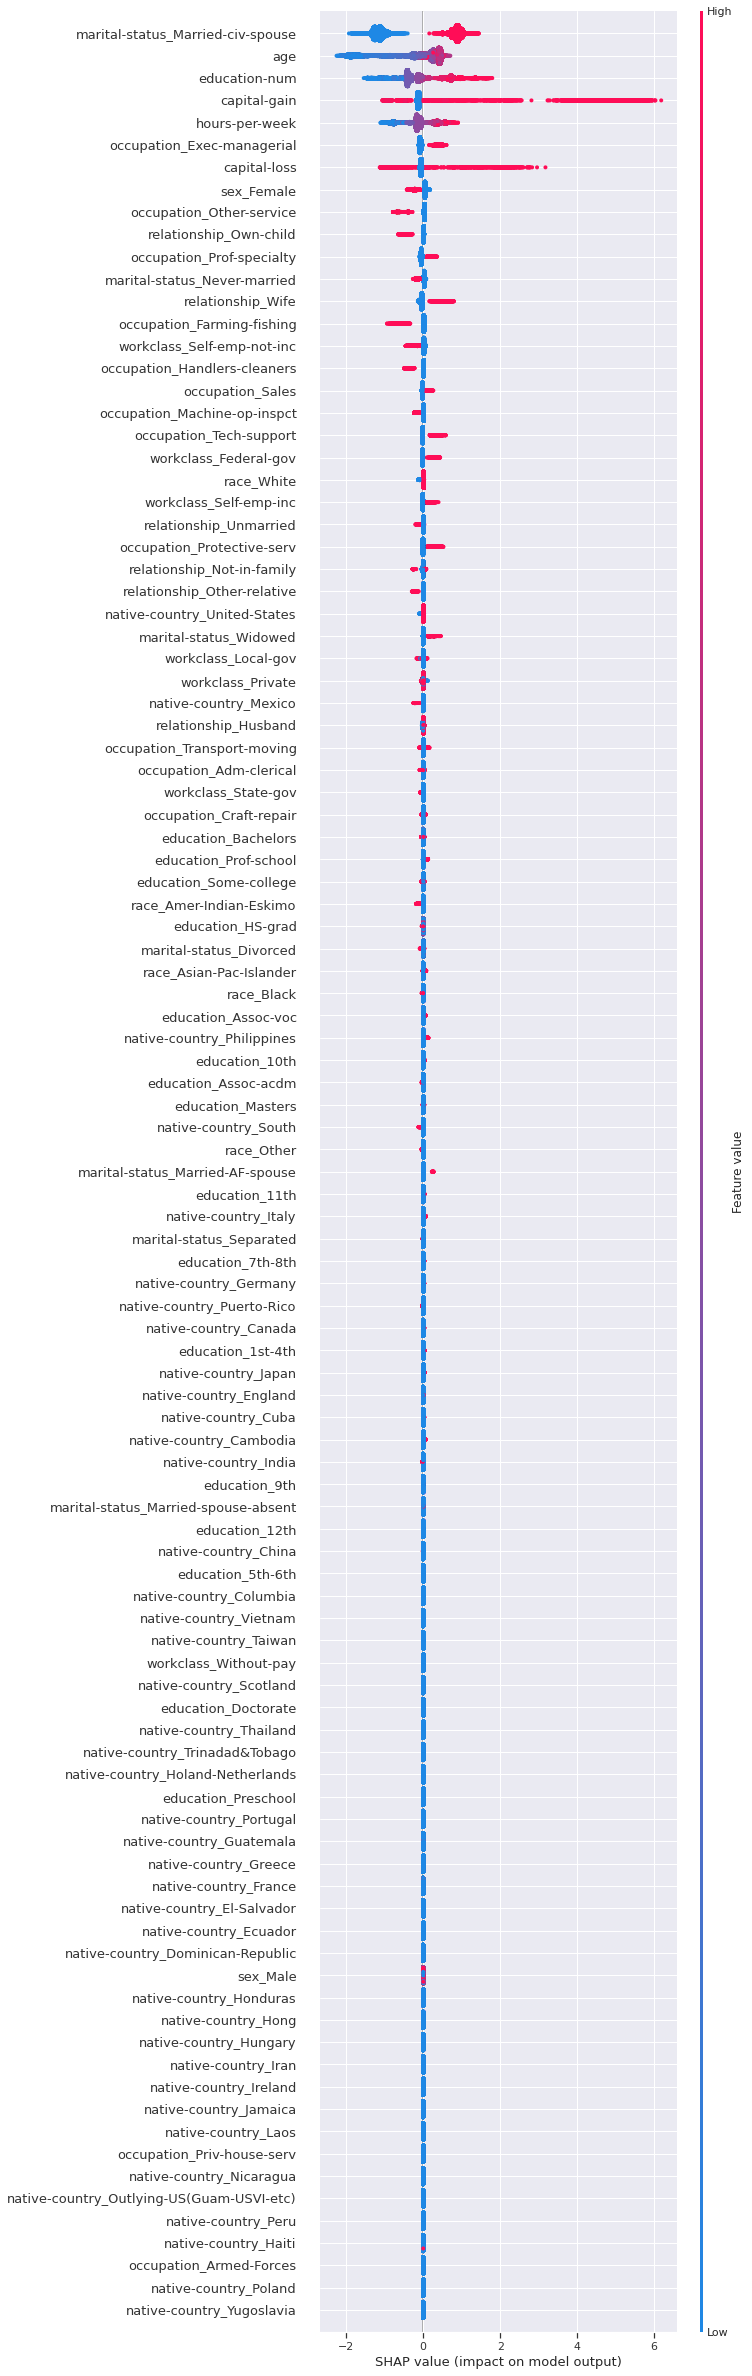

In [101]:
sns.set()
shap.summary_plot(shap_values, X,  max_display = shap_values.shape[1])

In [103]:
shap_df1.to_csv("Adult_census_shap_1.csv", index = False)

In [104]:
shap_df1

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,...,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.275228,0.622901,-0.467674,-0.041441,-0.187412,-0.010134,0.002197,-0.005174,-0.004905,0.017008,-0.055837,0.0,-0.000193,-0.000042,-0.000011,-0.000028,-2.644124e-06,-0.000046,-0.000021,0.000245,-0.000270,-0.002503,0.0,-0.000109,-0.000014,0.0,-0.001399,-0.000407,0.000282,-0.000178,-1.248021,-0.000005,-0.112568,0.000046,-0.002632,-0.024462,0.0,0.002053,-0.076582,0.021147,...,-0.000069,0.000019,0.000004,-0.000048,0.0,0.0,0.0,-0.000047,0.0,-0.000060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000057,0.0,0.0,-0.000136,0.0,-0.000040,0.0,0.001659,0.0,0.0,0.0,-0.000366,0.0,0.0,0.000077,0.0,0.000294,-0.000001,0.0,0.0,0.005718,0.000001,0.0
1,0.366783,0.636638,-0.168850,-0.096398,-1.027270,-0.011599,0.002167,-0.019439,-0.008465,-0.304793,0.002083,0.0,-0.000306,-0.000060,-0.000007,-0.000030,-2.600713e-06,-0.000137,-0.000016,0.000337,-0.000373,-0.006556,0.0,0.000256,-0.000821,0.0,-0.002668,-0.000388,-0.000030,-0.000159,0.926197,-0.000094,0.018356,0.000124,-0.002541,0.000509,0.0,0.002604,0.280104,0.022664,...,-0.000054,0.000019,0.000008,-0.000039,0.0,0.0,0.0,-0.000045,0.0,-0.000080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000085,0.0,0.0,-0.000193,0.0,-0.000037,0.0,0.001670,0.0,0.0,0.0,-0.000307,0.0,0.0,0.000077,0.0,0.000276,-0.000001,0.0,0.0,0.004904,0.000002,0.0
2,0.155801,-0.378785,-0.125408,-0.037547,-0.167630,-0.013071,0.001432,-0.002409,-0.006029,0.017274,0.002129,0.0,-0.000200,-0.000293,-0.000011,-0.000035,-8.843214e-07,-0.000046,-0.000248,0.000332,-0.000379,0.000451,0.0,0.005939,-0.000171,0.0,-0.001113,-0.001483,0.006391,-0.000212,-1.239140,-0.000023,0.022392,0.000071,-0.002847,0.001201,0.0,0.001639,-0.080161,0.019729,...,-0.000082,0.000019,0.000006,-0.000073,0.0,0.0,0.0,-0.000051,0.0,-0.000078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000052,0.0,0.0,-0.000138,0.0,-0.000039,0.0,0.002538,0.0,0.0,0.0,-0.000312,0.0,0.0,0.000074,0.0,0.000211,-0.000001,0.0,0.0,0.003205,0.000002,0.0
3,0.436197,-1.112285,-0.154441,-0.064088,-0.093813,-0.013627,0.001370,-0.004068,-0.008834,0.020994,0.001061,0.0,-0.003156,0.006975,-0.000011,-0.000040,-1.031430e-06,-0.000131,-0.000331,0.000419,-0.000301,0.000623,0.0,-0.008971,-0.000134,0.0,-0.001075,-0.000979,-0.000292,-0.000165,0.748033,-0.000012,0.021496,0.000129,-0.0025

Negative SHAP values for high value of female indicate bias based on sex

In [105]:
X = X.rename(columns={"sex_Female": "female"})

Randomize female attribue

In [106]:
#Hack
data_final = X.copy()

In [107]:
data_final['female_random'] = np.random.permutation(data_final['female'])

np.sum(data_final['female_random']==data_final['female'])

25418

In [108]:
data_final['male'] = 1 - data_final['female']

In [109]:
print(data_final.shape)

(45222, 105)


In [110]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(y.shape)
print(y_train.shape)
print(y_test.shape)

(45222, 103)
(30162, 103)
(15060, 103)
(45222,)
(30162,)
(15060,)


In [ ]:
X_train = data_final[:30162]
X_test = data_final[30162:]
X_r = data_final
xgb_full = xgboost.DMatrix(X_r, label=y)
xgb_train =  xgboost.DMatrix(X_train, label = y_train)
xgb_test = xgboost.DMatrix(X_test, label = y_test)
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"auc",
    "subsample": 0.5
}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model = xgboost.train(params, xgb_full, 5000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params,xgb_full, nfold = 3, metrics="auc" , num_boost_round=10)
pred = model.predict(xgb_full)

[0]	test-auc:0.868954
[1000]	test-auc:0.908598
[2000]	test-auc:0.916192
[3000]	test-auc:0.920743
[4000]	test-auc:0.924098
[4999]	test-auc:0.926607


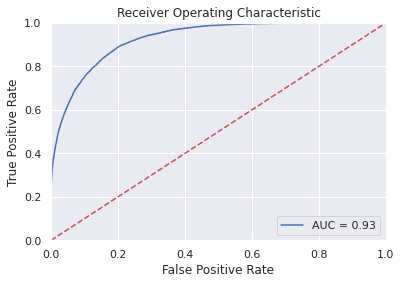

Optimal Threshold obtained using difference of TPR and FPR 0.2380492


In [ ]:
fpr, tpr , thresholds = roc_curve(y, pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
y_pred = np.where(pred > optimal_threshold, 1, 0)

In [ ]:
X_r = data_final.copy()
explainer = shap.TreeExplainer(model)
shap_values =  explainer.shap_values(X_r)

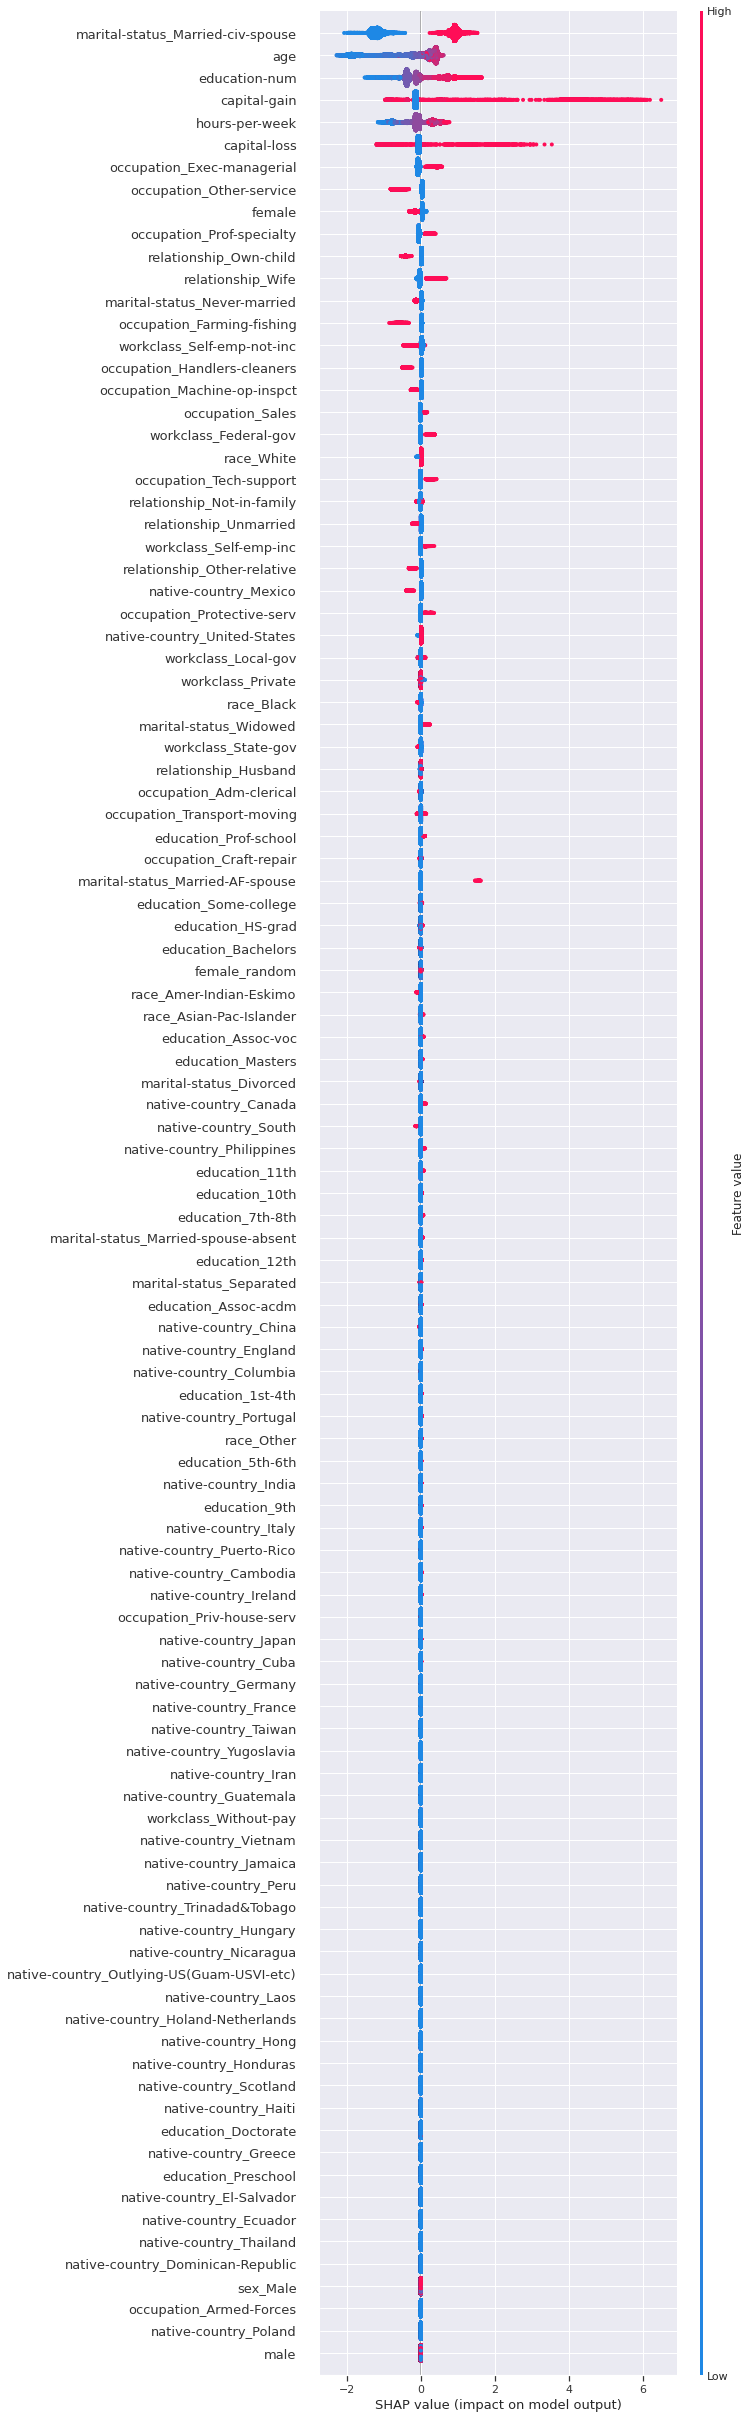

In [ ]:
sns.set()
shap.summary_plot(shap_values, X_r, max_display=shap_values.shape[1])

In [ ]:
independent_columns = list(X_r)
shap_df2 = pd.DataFrame(shap_values, columns=independent_columns)
shap_df2.to_csv("Adult_census_shap_randomized.csv", index = False)

# General Distribution for Sex and  Randomized Sex

In [113]:
sex_female = data_final[(data_final['female']==1)].index
sex_male = data_final[(data_final['female']==0)].index

print("Number of Females  is " + str(len(sex_female)))
print("Number of Males  is " + str(len(sex_male)))

location_female  =  data_final.columns.get_loc("female")
location_male = data_final.columns.get_loc("male")
location_rand = data_final.columns.get_loc("female_random")

Number of Females  is 14695
Number of Males  is 30527


60

In [114]:
locations_interested = [location_female,location_male, location_rand]

In [115]:
def get_pmf(data, num_bins = 100):
  counts, bins = np.histogram(data ,bins=num_bins)
  bins = bins[:-1] + (bins[1] - bins[0])/2
  probs = counts/float(counts.sum())
  return probs

IndexError: ignored

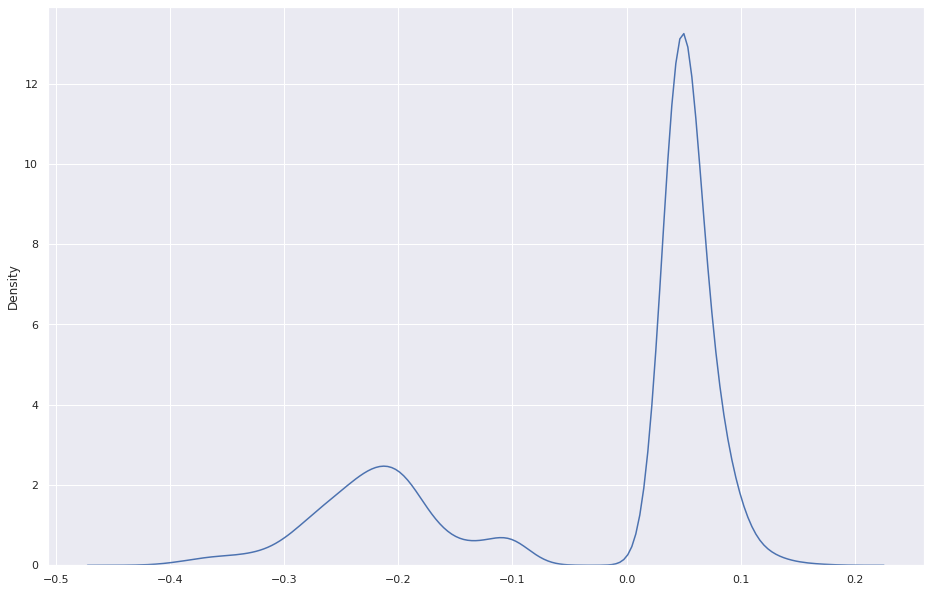

In [116]:
sns.kdeplot(shap_values[:, location_female], label = 'Sex = Female')
sns.kdeplot(shap_values[:, location_rand], label = 'Sex = Randomized Female')

pmf_rand =  get_pmf(shap_values[:, location_rand])
pmf_orig =  get_pmf(shap_values[:, location_female])
print("KL Divergence of the two distributions " + str(entropy(pmf_rand + 0.001, pmf_orig +0.001)))
print("KL Divergence of the two distributions " + str(entropy(pmf_orig + 0.001, pmf_rand +0.001)))

plt.legend()
plt.show()

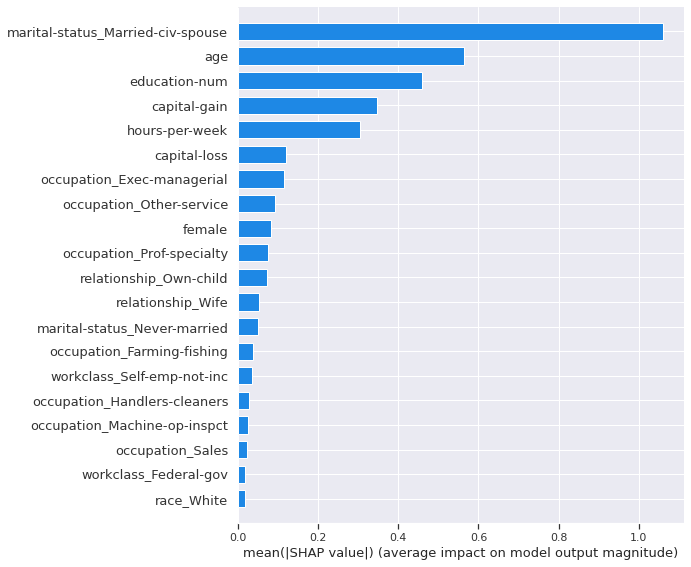

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")

#IGNORE
# Removing original sex column and randomizing sex

In [ ]:
#IGNORE
X_s =  data_final.drop(columns=['ground_truth','female','male','married_and_sex_male_div_sep','married_and_sex_female_div_sep_married','married_and_sex_male_single','married_and_sex_male_married_widowed','pred','y_pred'])
y =  data_final.loc[:, 'ground_truth']
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size =  0.2, random_state =  4)

xgb_full = xgboost.DMatrix(X_s, label=y)
xgb_train =  xgboost.DMatrix(X_train, label = y_train)
xgb_test = xgboost.DMatrix(X_test, label = y_test)
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"auc",
    "subsample": 0.5
}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model = xgboost.train(params, xgb_full, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params,xgb_full, nfold = 3, metrics="auc" , num_boost_round=10)
data_final['pred'] = model.predict(xgb_full)

fpr, tpr , thresholds = roc_curve(y, data_final['pred'])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
data_final['y_pred'] = np.where(data_final['pred'] > optimal_threshold, 1, 0)

explainer = shap.TreeExplainer(model)
shap_values =  explainer.shap_values(X_s)

# Separation or Equalized Odds

In [42]:
print(data_final.shape)
data_final = pd.concat([data_final.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
print(data_final.shape)

(45222, 104)
(45222, 105)


In [43]:
data_final = data_final.rename(columns={"income": "ground_truth"})

In [44]:
Y_1_F =  data_final[(data_final['ground_truth']==1) & (data_final['female']==1)].index
Y_1_M = data_final[(data_final['ground_truth']==1) & (data_final['female']==0)].index

Y_1_F_random =  data_final[(data_final['ground_truth']==1) & (data_final['female_random']==1)].index
Y_1_M_random = data_final[(data_final['ground_truth']==1) & (data_final['female_random']==0)].index



Y_0_F =  data_final[(data_final['ground_truth']==0) & (data_final['female']==1)].index
Y_0_M = data_final[(data_final['ground_truth']==0) & (data_final['female']==0)].index

Y_0_F_random =  data_final[(data_final['ground_truth']==0) & (data_final['female_random']==1)].index
Y_0_M_random = data_final[(data_final['ground_truth']==0) & (data_final['female_random']==0)].index
print("Should decrease number of females with low income and increase number of males with low income")
print("Number of Y=0 instances given female: " + str(len(Y_0_F)))
print("Number of Y=0 instances given male: " + str(len(Y_0_M)))
print("Number of Y=0 instances given female_random: " + str(len(Y_0_F_random)))
print("Number of Y=0 instances given male_random: " + str(len(Y_0_M_random)))
print()

print("Should increase number of females with high income and decrease number of males with high income")
print("Number of Y=1 instances given female: " + str(len(Y_1_F)))
print("Number of Y=1 instances given male: " + str(len(Y_1_M)))
print("Number of Y=1 instances given female_random: " + str(len(Y_1_F_random)))
print("Number of Y=1 instances given male_random: " + str(len(Y_1_M_random)))

KeyError: ignored

In [ ]:
X=X_r #Hack here
X_set =  X.iloc[Y_0_F]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_0_female_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)


X_set =  X.iloc[Y_0_M]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_0_male_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)

X_set =  X.iloc[Y_0_F_random]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_0_female_random_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)


X_set =  X.iloc[Y_0_M_random]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_0_male_random_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)

KL Divergence of the two distributions 1.6800177719456841
KL Divergence of the two distributions 1.7421451798208736


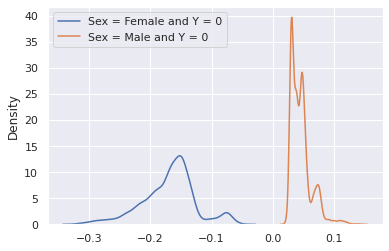

In [ ]:
sns.kdeplot(y_0_female_values[:,0], label = 'Sex = Female and Y = 0')
sns.kdeplot(y_0_male_values[:,0], label = 'Sex = Male and Y = 0')
pmf_rand =  get_pmf(y_0_female_values[:,0])
pmf_orig =  get_pmf(y_0_male_values[:,0])
print("KL Divergence of the two distributions " + str(entropy(pmf_rand + 0.001, pmf_orig +0.001)))
print("KL Divergence of the two distributions " + str(entropy(pmf_orig + 0.001, pmf_rand +0.001)))

plt.legend()
plt.show()

Equality of opportunity requires that the distribution of SHAP values of the protected attribute for true advantageous outcome (Y=1) should be similar. These distributions have a fairly high KL divergence and so are dissimilar.

Equalized Odds requires that given a particular true outcome (Y=0 or Y=1), the SHAP explanation for the protected attribute should be similar for different protected classes. 

KL Divergence of the two distributions 0.19427632822538948
KL Divergence of the two distributions 0.29749423173094436


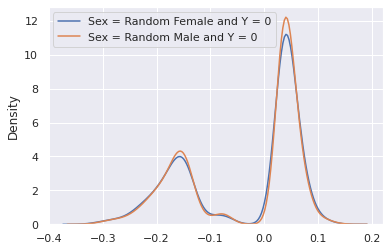

In [ ]:
sns.kdeplot(y_0_female_random_values[:,0], label = 'Sex = Random Female and Y = 0')
sns.kdeplot(y_0_male_random_values[:,0], label = 'Sex = Random Male and Y = 0')

pmf_rand =  get_pmf(y_0_female_random_values[:,0])
pmf_orig =  get_pmf(y_0_male_random_values[:,0])
print("KL Divergence of the two distributions " + str(entropy(pmf_rand + 0.001, pmf_orig +0.001)))
print("KL Divergence of the two distributions " + str(entropy(pmf_orig + 0.001, pmf_rand +0.001)))

plt.legend()
plt.show()

# Equality of Opportunity

In [ ]:
X_set =  X.iloc[Y_1_F]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_1_female_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)


X_set =  X.iloc[Y_1_M]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_1_male_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)

X_set =  X.iloc[Y_1_F_random]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_1_female_random_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)


X_set =  X.iloc[Y_1_M_random]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_1_male_random_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)

KL Divergence of the two distributions 2.245842520545213
KL Divergence of the two distributions 2.604629046471304


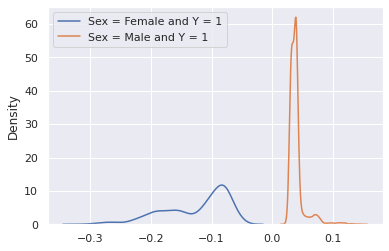

In [ ]:
sns.kdeplot(y_1_female_values[:,0], label = 'Sex = Female and Y = 1')
sns.kdeplot(y_1_male_values[:,0], label = 'Sex = Male and Y = 1')
pmf_rand =  get_pmf(y_1_female_values[:,0])
pmf_orig =  get_pmf(y_1_male_values[:,0])
print("KL Divergence of the two distributions " + str(entropy(pmf_rand + 0.001, pmf_orig +0.001)))
print("KL Divergence of the two distributions " + str(entropy(pmf_orig + 0.001, pmf_rand +0.001)))
plt.legend()
plt.show()

#Recourse

In [43]:
shap_df = pd.read_csv("Adult_census_shap.csv")
shap_values = shap_df.values

In [120]:
shap_df = pd.DataFrame(shap_values, columns = X.columns)
shap_df.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,...,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.275228,0.622901,-0.467674,-0.041441,-0.187412,-0.010134,0.002197,-0.005174,-0.004905,0.017008,-0.055837,0.0,-0.000193,-0.000042,-0.000011,-0.000028,-2.644124e-06,-0.000046,-0.000021,0.000245,-0.000270,-0.002503,0.0,-0.000109,-0.000014,0.0,-0.001399,-0.000407,0.000282,-0.000178,-1.248021,-0.000005,-0.112568,0.000046,-0.002632,-0.024462,0.0,0.002053,-0.076582,0.021147,...,-0.000069,0.000019,0.000004,-0.000048,0.0,0.0,0.0,-0.000047,0.0,-0.000060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000057,0.0,0.0,-0.000136,0.0,-0.000040,0.0,0.001659,0.0,0.0,0.0,-0.000366,0.0,0.0,0.000077,0.0,0.000294,-0.000001,0.0,0.0,0.005718,0.000001,0.0
1,0.366783,0.636638,-0.168850,-0.096398,-1.027270,-0.011599,0.002167,-0.019439,-0.008465,-0.304793,0.002083,0.0,-0.000306,-0.000060,-0.000007,-0.000030,-2.600713e-06,-0.000137,-0.000016,0.000337,-0.000373,-0.006556,0.0,0.000256,-0.000821,0.0,-0.002668,-0.000388,-0.000030,-0.000159,0.926197,-0.000094,0.018356,0.000124,-0.002541,0.000509,0.0,0.002604,0.280104,0.022664,...,-0.000054,0.000019,0.000008,-0.000039,0.0,0.0,0.0,-0.000045,0.0,-0.000080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000085,0.0,0.0,-0.000193,0.0,-0.000037,0.0,0.001670,0.0,0.0,0.0,-0.000307,0.0,0.0,0.000077,0.0,0.000276,-0.000001,0.0,0.0,0.004904,0.000002,0.0
2,0.155801,-0.378785,-0.125408,-0.037547,-0.167630,-0.013071,0.001432,-0.002409,-0.006029,0.017274,0.002129,0.0,-0.000200,-0.000293,-0.000011,-0.000035,-8.843214e-07,-0.000046,-0.000248,0.000332,-0.000379,0.000451,0.0,0.005939,-0.000171,0.0,-0.001113,-0.001483,0.006391,-0.000212,-1.239140,-0.000023,0.022392,0.000071,-0.002847,0.001201,0.0,0.001639,-0.080161,0.019729,...,-0.000082,0.000019,0.000006,-0.000073,0.0,0.0,0.0,-0.000051,0.0,-0.000078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000052,0.0,0.0,-0.000138,0.0,-0.000039,0.0,0.002538,0.0,0.0,0.0,-0.000312,0.0,0.0,0.000074,0.0,0.000211,-0.000001,0.0,0.0,0.003205,0.000002,0.0
3,0.436197,-1.112285,-0.154441,-0.064088,-0.093813,-0.013627,0.001370,-0.004068,-0.008834,0.020994,0.001061,0.0,-0.003156,0.006975,-0.000011,-0.000040,-1.031430e-06,-0.000131,-0.000331,0.000419,-0.000301,0.000623,0.0,-0.008971,-0.000134,0.0,-0.001075,-0.000979,-0.000292,-0.000165,0.748033,-0.000012,0.021496,0.000129,-0.0025

In [121]:
## Creating the dataset for adult census values
data_final['id'] =  np.arange(0, data_final.shape[0])
shap_sex = (shap_values[:, location_female])
group = X.iloc[:, location_female]
label = y#data_final['ground_truth']
#pred =  data_final['pred']
id = data_final['id']
group = group.reset_index(drop=True)
#data_recourse = pd.reset_index(inplace=True)
#,ignore_index=True
data_recourse = pd.DataFrame({'id':id.values, 'shap':shap_sex,'label':label,'group':group.values, 'prediction':pred})#, 'prediction':pred})

#data_final.head()
data_recourse.head()

,id,shap,label,group,prediction
0,0,0.086879,0,0.0,0.075122
1,1,0.037214,0,0.0,0.323197
2,2,0.070438,0,0.0,0.029478
3,3,0.046967,0,0.0,0.108480
4,4,-0.098444,0,1.0,0.538363


In [122]:
data_recourse.to_csv("even_better_shap_adult.csv", index = False)

Parts of the code below are adopted from the  code for the papers One Fairness and Calibration 
https://github.com/gpleiss/equalized_odds_and_calibration

In [123]:
class Model(namedtuple('Model', 'id shap pred label')):
  
    def logits(self):
        raw_logits = np.clip(np.log(self.pred / (1 - self.pred)), -100, 100)
        return raw_logits

    def num_samples(self):
        return len(self.pred)

    def base_rate(self):
        """
        Percentage of samples belonging to the positive class
        """
        #jump
        return np.mean(self.label)

    def accuracy(self):
        return self.accuracies().mean()

    def precision(self):
        return (self.label[self.pred.round() == 1]).mean()

    def recall(self):
        return (self.label[self.label == 1].round()).mean()

    def tpr(self):
        """
        True positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 1))

    def fpr(self):
        """
        False positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 0))

    def tnr(self):
        """
        True negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 0))

    def fnr(self):
        """
        False negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 1))

    def fn_cost(self):
        """
        Generalized false negative cost
        """
        return 1 - self.pred[self.label == 1].mean()

    def fp_cost(self):
        """
        Generalized false positive cost
        """
        return self.pred[self.label == 0].mean()

    def accuracies(self):
        return self.pred.round() == self.label
    
    def trivial(self):
        """
        Given a classifier, produces the trivial classifier
        (i.e. a model that just returns the base rate for every prediction)
        """
        base_rate = self.base_rate()
        pred = np.ones(len(self.pred)) * base_rate
        return Model(self.id, self.shap, pred, self.label)

    def weighted_cost(self, fp_rate, fn_rate, w_fp = 1, w_fn = 1):
        """
        Returns the weighted cost
        If fp_rate = 1 and fn_rate = 0, returns self.fp_cost
        If fp_rate = 0 and fn_rate = 1, returns self.fn_cost
        If fp_rate and fn_rate are nonzero, returns fp_rate * self.fp_cost * (1 - self.base_rate) +
            fn_rate * self.fn_cost * self.base_rate
        """
        norm_const = float(w_fp *fp_rate + w_fn *fn_rate) if (fp_rate != 0 and fn_rate != 0) else 1
        res = w_fp*fp_rate / norm_const * self.fp_cost() * (1 - self.base_rate()) + \
            w_fn*fn_rate / norm_const * self.fn_cost() * self.base_rate()
        return res
    
    def calib_eq_odds(self, other, fp_rate, fn_rate, shap_enabled =  False, mix_rates=None):
        if mix_rates is None:
          if fn_rate == 0:
              self_cost = self.fp_cost()
              other_cost = other.fp_cost()
              print(self_cost, other_cost)
              self_trivial_cost = self.trivial().fp_cost()
              other_trivial_cost = other.trivial().fp_cost()
          elif fp_rate == 0:
              self_cost = self.fn_cost()
              other_cost = other.fn_cost()
              self_trivial_cost = self.trivial().fn_cost()
              other_trivial_cost = other.trivial().fn_cost()
          else:
              w_fp =1
              w_fn =1
              self_cost = self.weighted_cost(fp_rate, fn_rate, w_fp, w_fn)
              other_cost = other.weighted_cost(fp_rate, fn_rate, w_fp, w_fn)
              self_trivial_cost = self.trivial().weighted_cost(fp_rate, fn_rate, w_fp, w_fn)
              other_trivial_cost = other.trivial().weighted_cost(fp_rate, fn_rate, w_fp, w_fn)

  #         print("The costs are ", self_cost, other_cost, self_trivial_cost, other_trivial_cost)
          other_costs_more = other_cost > self_cost
          self_mix_rate = (other_cost - self_cost) / (self_trivial_cost - self_cost) if other_costs_more else 0
          other_mix_rate = 0 if other_costs_more else (self_cost - other_cost) / (other_trivial_cost - other_cost)
          print("The mix_rates are ", self_mix_rate, other_mix_rate)
        else:
          self_mix_rate = mix_rates[0]
          other_mix_rate = mix_rates[1]
        # New classifiers
        
#         self_indices = np.random.permutation(len(self.pred))[:int(self_mix_rate * len(self.pred))]
#         self_new_pred = self.pred.copy()
#         self_new_pred[self_indices] = self.base_rate()
#         calib_eq_odds_self = Model(self.id, self.shap, self_new_pred, self.label)

#         print("Running the post processing for group 0 ")
        if shap_enabled:
          self_changed_id, self_new_pred = self.shap_fair_individuals_calibrated(self_mix_rate, advantaged  = True)
        else:
          self_changed_id, self_new_pred = self.randomized_fair_individuals_calibrated(self_mix_rate)
        
        
       
          
        calib_eq_odds_self = Model(self_changed_id, self.shap, self_new_pred, self.label)
        
        if self_mix_rate >0:
          print("Changing SELF Model--------------- for self mix rate ", self_mix_rate)
#           print(self_changed_id)
          df = self.get_pandas_df()
#           print(df.head(2))
#           df.loc[self_changed_id,'pred'].hist()
#           plt.title('Prediction')
#           plt.show()
          
          df.plot.scatter(x ='shap', y='pred')
          plt.axhline(y=self.base_rate(), color='r', linestyle='-')
          plt.title("Choosing " +str(len(self_changed_id)) + " Individuals from " + str(len(self_changed_id)) + "individuals")
          plt.show()
        else:
          print("Number of people with equal predictions in self " , np.sum(self_new_pred==self.pred))


#         other_indices = np.random.permutation(len(other.pred))[:int(other_mix_rate * len(other.pred))]
#         other_new_pred = other.pred.copy()
#         other_new_pred[other_indices] = other.base_rate()
#         calib_eq_odds_other = Model(other.id, other.shap, other_new_pred, other.label)

        if shap_enabled:
          other_changed_id, other_new_pred = other.shap_fair_individuals_calibrated(other_mix_rate, advantaged = False)
        else:
          other_changed_id, other_new_pred = other.randomized_fair_individuals_calibrated(other_mix_rate)
        sns.set(rc={'figure.figsize':(5.7,5.27)})

        
          
        calib_eq_odds_other = Model(other_changed_id, other.shap, other_new_pred, other.label)
    
        if other_mix_rate >0:
          print("Changing Other Model--------------- for other mix rate ", other_mix_rate)
#           print(other_changed_id)
          df = other.get_pandas_df()
#           print(df.head(2))
#           df.loc[other_changed_id,'pred'].hist()
#           plt.title('Prediction Distribution')
#           plt.show()
    
#           df.loc[other_changed_id,'shap'].hist()
#           plt.title('SHAp Value Distribution')

#           plt.show()
#           sns.scatterplot(x =df.loc[other_changed_id,'shap'], y= df.loc[other_changed_id,'pred'])
#           plt.title('')
#           plt.axhline(y=other.base_rate(), color='r', linestyle='-')

#           plt.show()
          sns.set(rc={'figure.figsize':(12.7,8.27)})
          df.plot.scatter(x ='shap', y='pred')
          plt.axhline(y=other.base_rate(), color='g', linestyle='--', linewidth = 5)
          plt.axvline(x=0, color='g', linestyle='--', linewidth = 5)
          plt.xlim(-0.1, 0.1)
          plt.title("Need to choose " +str(len(other_changed_id)) + " people from " + str(len(other.shap)) + " individuals")
          plt.show()
        else:
          print("Number of people with equal predictions in self " , np.sum(other_new_pred==other.pred))
        

        if mix_rates is None:
            return calib_eq_odds_self, calib_eq_odds_other, (self_mix_rate, other_mix_rate)
        else:
            return calib_eq_odds_self, calib_eq_odds_other
          
    def shap_fair_individuals_calibrated(self, mix_rate , advantaged):
        total = len(self.id)
        num_changed =int(mix_rate * total)
        df = self.get_pandas_df()
        print("In SHAP Method Number of people changed %d and total number %d " % (num_changed, total) )

        base_rate = self.base_rate()
        if advantaged:
          if mix_rate > 0:
            print("Redistributing Predictions for Advantaged Group")
            
          

            

#           df['except_race'] =  df['pred'] - df['shap']
          changed_indices = df.sort_values('shap', ascending = False).index[:num_changed]
#           changed_indices = df.sort_values('except_race', ascending = False).index[:num_changed]

          df.loc[changed_indices, 'pred'] = self.base_rate()
  #         print("After changning pred value")
  #         print(df.head())
        else:
          if mix_rate > 0:
            print("Redistributing Predictions for Dis Advantaged Group")
            
          quadrant_1 = df[(df['shap'] > 0) & (df['pred'] > base_rate)].index
          quadrant_2 = df[(df['shap'] < 0) & (df['pred'] > base_rate)].index
          quadrant_3 = df[(df['shap'] <= 0) & (df['pred'] <= base_rate)].index
          quadrant_4 = df[(df['shap'] >= 0)& (df['pred'] <= base_rate)].index
          df['distance'] =  np.sqrt(np.square(df['shap']) + np.square(df['pred'] - base_rate))  
          print("Number of people in each quadrant ", len(quadrant_1),len(quadrant_2),len(quadrant_3),len(quadrant_4))
          
          required_changed_ids = num_changed
          print(required_changed_ids)
          changed_indices1 = (list(df.loc[(quadrant_1.union(quadrant_3))].sort_values('distance', ascending = False).index[:required_changed_ids]))
          print("People taken from Quadrant 1 and 3 ", len(changed_indices1))
          required_changed_ids -= len(changed_indices1)
          print("ID 's left to take  Adfter Quadrant 1 and 3 ", required_changed_ids)
          changed_indices2 = list(df.loc[quadrant_2.union(quadrant_4)].sort_values('distance', ascending = True).index[:required_changed_ids])
          required_changed_ids -= len(changed_indices2)
          print("Number of ids changed in the end ", len(changed_indices2))
          changed_indices = changed_indices1+ changed_indices2
            
          #changed_indices = df.sort_values('shap', ascending = True).index[:num_changed]
          
          
          df.loc[changed_indices, 'pred'] = self.base_rate()
          

          

        return changed_indices, df.pred.copy()
    
    
    
    def randomized_fair_individuals_calibrated(self, mix_rate):
        total = len(self.id)
        changed_indices = np.random.permutation(self.id)[:int(mix_rate * total)]
#         print("In randmoized Number of people changed %d and total number %d " % (len(changed_indices), total) ) 
      
        df = self.get_pandas_df()
        
        df.loc[changed_indices, 'pred'] = self.base_rate()
#         print("After changning pred value")
#         print(df.loc[changed_indices].head(10))
# 
        return changed_indices, df.pred.copy() 

    def randomized_fair_individuals_equalized(self, p2p, n2p):
        from sklearn.utils import shuffle

        df = self.get_pandas_df()
        df['pred_outcome'] = df['pred'].round()
        original_pos =  df[df['pred_outcome'] == 1]
        # Changing positive predictions
        no_p2n= int(original_pos.shape[0] *  (1 - p2p))
        original_pos =  shuffle(original_pos)     
        p2n_indices = original_pos.head(no_p2n).index
        df.loc[p2n_indices, 'pred'] = 1 - df.loc[p2n_indices, 'pred']      
        
        #Changing negative predictions
        original_neg = df[df['pred_outcome']==0]
        no_n2p= int(original_neg.shape[0] *  (n2p))
        n2p_indices = original_neg.head(no_n2p).index
        df.loc[n2p_indices, 'pred'] = 1 - df.loc[n2p_indices, 'pred']      

        changed_ids = np.append(n2p_indices, p2n_indices)
        return changed_ids, df.pred.copy()

    def shap_fair_individuals_equalized(self, p2p, n2p):

        df = self.get_pandas_df()
        df['pred_outcome'] = df['pred'].round()
        original_pos =  df[df['pred_outcome'] == 1]
        # Changing positive predictions
        # Flipping positive predictions for people with lowest prediction without their race
        no_p2n= int(original_pos.shape[0] *  (1 - p2p))
        original_pos['pred_except_race_shap'] = original_pos['pred']-original_pos['shap']
        p2n_indices = np.asarray(original_pos.sort_values('pred_except_race_shap', ascending = True).index[:no_p2n])
        df.loc[p2n_indices, 'pred'] = 1 - df.loc[p2n_indices, 'pred']      
        
        #Changing negative predictions
        # Flipping Negative Predictions for people with highest contribution except SHAP
        original_neg = df[df['pred_outcome']==0]
        no_n2p= int(original_neg.shape[0] *  (n2p))
        original_neg['pred_except_race_shap'] = original_neg['pred']-original_neg['shap']
        n2p_indices = np.asarray(original_neg.sort_values('pred_except_race_shap', ascending = False).index[:no_n2p])
        df.loc[n2p_indices, 'pred'] = 1 - df.loc[n2p_indices, 'pred']      

        changed_ids = np.append(n2p_indices, p2n_indices)
        return changed_ids, df.pred.copy()
    
    def get_pandas_df(self):
        a = pd.DataFrame({'id':self.id, 'shap':self.shap,'label':self.label, 'pred':self.pred})
        a.set_index('id', inplace =  True)
        return a
        
    def get_changed_id(self):
      return self.id

    def eq_odds(self, other, shap_enabled =  False, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(other)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
        print("sp2p, sn2p, op2p, on2p ", sp2p, sn2p, op2p, on2p)
#         self_fair_pred = self.pred.copy()
        ## Original Positive Predictions
#         self_pp_indices, = np.nonzero(self.pred.round())        
        ## Original Negative Predictions
#         self_pn_indices, = np.nonzero(1 - self.pred.round())
        
        
#         np.random.shuffle(self_pp_indices)
#         np.random.shuffle(self_pn_indices)
        
        
#         print("Self Negative to Postive Rate ", sn2p)
#         #print("Self Postive Indices Shuffled ", self_pp_indices[:5])
        
#         self_n2p_indices = self_pn_indices[:int(len(self_pn_indices) * sn2p)]
#         print("Length of self n2p indices ", len(self_n2p_indices))
#         #print("Before ", self_fair_pred)
#         self_fair_pred[self_n2p_indices] = 1 - self_fair_pred[self_n2p_indices]
#         #print("After ", self_fair_pred)
        
#         print("Self Positive to Negative Rate ", 1 - sp2p)
                
#         self_p2n_indices = self_pp_indices[:int(len(self_pp_indices) * (1 - sp2p))]
#         print("Length of self p2n indices ", len(self_p2n_indices))

#         #print("Before ", self_fair_pred[self_p2n_indices])

#         self_fair_pred[self_p2n_indices] = 1 - self_fair_pred[self_p2n_indices]
#         #print("After ", self_fair_pred[self_p2n_indices])
#         self_changed_id =  np.append(self_p2n_indices, self_n2p_indices)
        df_self = self.get_pandas_df()
        if shap_enabled:
           print("using SHAP based selection of individuals for self ")
           self_changed_id, self_fair_pred = self.shap_fair_individuals_equalized(sp2p, sn2p)
      
        else:
          print("using random based selection of individuals for self ")
          self_changed_id, self_fair_pred = self.randomized_fair_individuals_equalized(sp2p, sn2p)

        df_self.loc[self_changed_id, 'pred'].hist()
        plt.show()
        df_self.loc[self_changed_id, 'shap'].hist()
        plt.show()
#         othr_fair_pred = othr.pred.copy()
#         othr_pp_indices, = np.nonzero(othr.pred.round())
#         othr_pn_indices, = np.nonzero(1 - othr.pred.round())
#         np.random.shuffle(othr_pp_indices)
#         np.random.shuffle(othr_pn_indices)
#         print("Other Negative to Postive Rate ", on2p)

#         other_n2p_indices = othr_pn_indices[:int(len(othr_pn_indices) * on2p)]
#         print("Length of Other n2p indices ", len(other_n2p_indices))

        
#         othr_fair_pred[other_n2p_indices] = 1 - othr_fair_pred[other_n2p_indices]

#         print("Other Negative to Postive Rate ", 1 - op2p)
        
#         other_p2n_indices = othr_pp_indices[:int(len(othr_pp_indices) * (1 - op2p))]
#         print("Length of Other p2n indices ", len(other_p2n_indices))

#         othr_fair_pred[other_p2n_indices] = 1 - othr_fair_pred[other_p2n_indices]
#         other_changed_id =  np.append(other_p2n_indices, other_n2p_indices)
#         print("Lengths of total other changed ids ", len(other_changed_id))
        df_other =  other.get_pandas_df()
        if shap_enabled:
          print("using SHAP based selection of individuals for other ")
          other_changed_id, other_fair_pred = other.shap_fair_individuals_equalized(op2p,on2p)
        else:
          print("using  random selection of individuals for other ")
          other_changed_id, other_fair_pred = other.randomized_fair_individuals_equalized(op2p,on2p)
        df_other.loc[other_changed_id,'pred'].hist()
        plt.show()

        df_other.loc[other_changed_id,'shap'].hist()
        plt.show()

        fair_self = Model(self_changed_id, self.shap, self_fair_pred, self.label)
        fair_other = Model(other_changed_id, other.shap, other_fair_pred, other.label)
  
        
        if not has_mix_rates:
            return fair_self, fair_other, mix_rates
        else:
            return fair_self, fair_other

          
          
    def eq_odds_optimal_mix_rates(self, othr):
      
        """Function to calculate mix rates for equalized odds"""
        np.random.seed(34)
        sbr = float(self.base_rate())
        obr = float(othr.base_rate())

        sp2p = cvx.Variable(1)
        sp2n = cvx.Variable(1)
        sn2p = cvx.Variable(1)
        sn2n = cvx.Variable(1)

        op2p = cvx.Variable(1)
        op2n = cvx.Variable(1)
        on2p = cvx.Variable(1)
        on2n = cvx.Variable(1)

        sfpr = self.fpr() * sp2p + self.tnr() * sn2p
        sfnr = self.fnr() * sn2n + self.tpr() * sp2n
        ofpr = othr.fpr() * op2p + othr.tnr() * on2p
        ofnr = othr.fnr() * on2n + othr.tpr() * op2n
        error = sfpr + sfnr + ofpr + ofnr

        sflip = 1 - self.pred
        sconst = self.pred
        oflip = 1 - othr.pred
        oconst = othr.pred

        sm_tn = np.logical_and(self.pred.round() == 0, self.label == 0)
        sm_fn = np.logical_and(self.pred.round() == 0, self.label == 1)
        sm_tp = np.logical_and(self.pred.round() == 1, self.label == 1)
        sm_fp = np.logical_and(self.pred.round() == 1, self.label == 0)

        om_tn = np.logical_and(othr.pred.round() == 0, othr.label == 0)
        om_fn = np.logical_and(othr.pred.round() == 0, othr.label == 1)
        om_tp = np.logical_and(othr.pred.round() == 1, othr.label == 1)
        om_fp = np.logical_and(othr.pred.round() == 1, othr.label == 0)

        spn_given_p = (sn2p * (sflip * sm_fn).mean() + sn2n * (sconst * sm_fn).mean()) / sbr + \
                      (sp2p * (sconst * sm_tp).mean() + sp2n * (sflip * sm_tp).mean()) / sbr

        spp_given_n = (sp2n * (sflip * sm_fp).mean() + sp2p * (sconst * sm_fp).mean()) / (1 - sbr) + \
                      (sn2p * (sflip * sm_tn).mean() + sn2n * (sconst * sm_tn).mean()) / (1 - sbr)

        opn_given_p = (on2p * (oflip * om_fn).mean() + on2n * (oconst * om_fn).mean()) / obr + \
                      (op2p * (oconst * om_tp).mean() + op2n * (oflip * om_tp).mean()) / obr

        opp_given_n = (op2n * (oflip * om_fp).mean() + op2p * (oconst * om_fp).mean()) / (1 - obr) + \
                      (on2p * (oflip * om_tn).mean() + on2n * (oconst * om_tn).mean()) / (1 - obr)

        constraints = [
            sp2p == 1 - sp2n,
            sn2p == 1 - sn2n,
            op2p == 1 - op2n,
            on2p == 1 - on2n,
            sp2p <= 1,
            sp2p >= 0,
            sn2p <= 1,
            sn2p >= 0,
            op2p <= 1,
            op2p >= 0,
            on2p <= 1,
            on2p >= 0,
            spp_given_n == opp_given_n,
            spn_given_p == opn_given_p,
        ]

        prob = cvx.Problem(cvx.Minimize(error), constraints)
        prob.solve()

        res = np.array([sp2p.value, sn2p.value, op2p.value, on2p.value])
        return res

      

    def __repr__(self):
        return '\n'.join([
            'Accuracy:\t%.3f' % self.accuracy(),
            'F.P. cost:\t%.3f' % self.fp_cost(),
            'F.N. cost:\t%.3f' % self.fn_cost(),
            'Base rate:\t%.3f' % self.base_rate(),
            'Avg. score:\t%.3f' % self.pred.mean(),
        ])

In [124]:
""# Cost constraint
cost_constraint = 'weighted'

if cost_constraint == 'fnr':
    fn_rate = 1
    fp_rate = 0
elif cost_constraint == 'fpr':
    fn_rate = 0
    fp_rate = 1
elif cost_constraint == 'weighted':
    fn_rate = 1
    fp_rate = 1
    
    
test_and_val_data = data_recourse
print(test_and_val_data.head())

# Randomly split the data into two sets - one for computing the fairness constants
np.random.seed(42)
order = np.random.permutation(len(test_and_val_data))
val_indices = order[0::2]
test_indices = order[1::2]
val_data = test_and_val_data.iloc[val_indices]
test_data = test_and_val_data.iloc[test_indices]


# Create model objects - one for each group, validation and test
group_0_val_data = val_data[val_data['group'] == 0]
group_1_val_data = val_data[val_data['group'] == 1]
group_0_test_data = test_data[test_data['group'] == 0]
group_1_test_data = test_data[test_data['group'] == 1]

#print(group_0_val_data.head())
#print(group_1_val_data.head())
#print(group_0_test_data.head())
#print(group_1_test_data.head())



group_0_val_model = Model(group_0_val_data['id'].to_numpy(),group_0_val_data['shap'].to_numpy(), group_0_val_data['prediction'].to_numpy(), 
                          group_0_val_data['label'].to_numpy())
group_1_val_model = Model(group_1_val_data['id'].to_numpy(), group_1_val_data['shap'].to_numpy(), group_1_val_data['prediction'].to_numpy(),
                          group_1_val_data['label'].to_numpy())
group_0_test_model = Model(group_0_test_data['id'].to_numpy(), group_0_test_data['shap'].to_numpy(), group_0_test_data['prediction'].to_numpy(), 
                           group_0_test_data['label'].to_numpy())
group_1_test_model = Model(group_1_test_data['id'].to_numpy(), group_1_test_data['shap'].to_numpy(), group_1_test_data['prediction'].to_numpy(), 
                           group_1_test_data['label'].to_numpy())

   id      shap  label  group  prediction
0   0  0.086879      0    0.0    0.075122
1   1  0.037214      0    0.0    0.323197
2   2  0.070438      0    0.0    0.029478
3   3  0.046967      0    0.0    0.108480
4   4 -0.098444      0    1.0    0.538363


# Equalized Odds as described by paper Equality of Opportunity in Supervised Learning

sp2p, sn2p, op2p, on2p  [0.91009237] [6.08235905e-11] [1.] [0.12065495]
using random based selection of individuals for self 


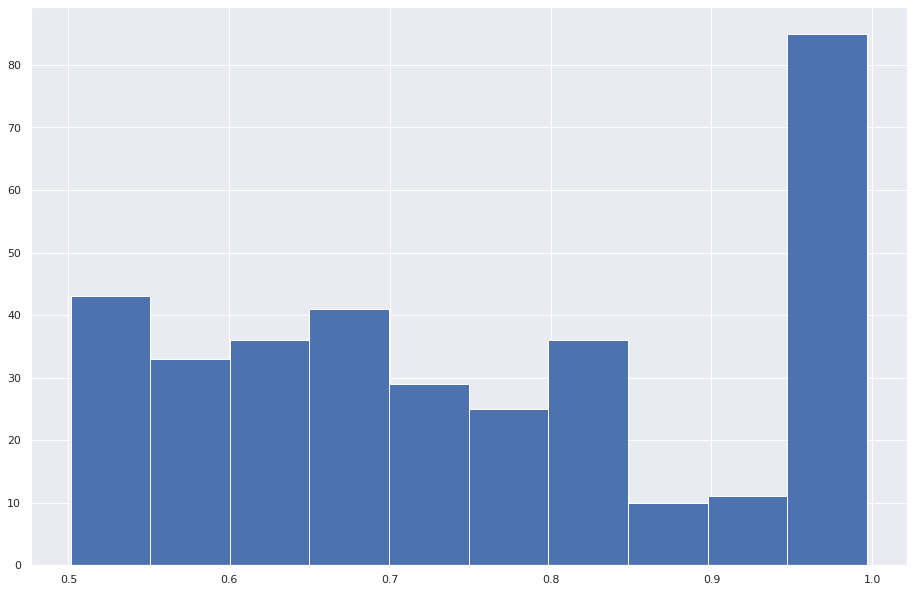

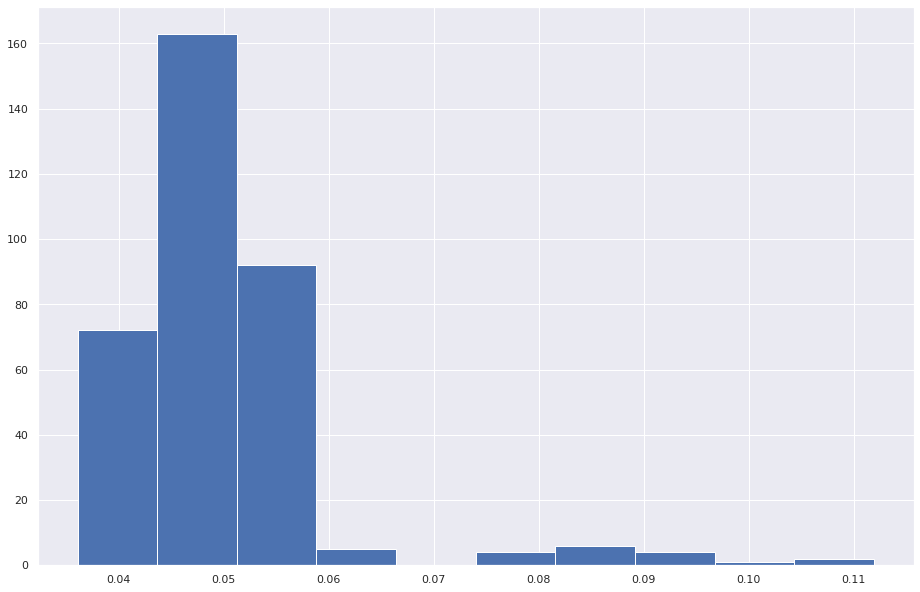

using  random selection of individuals for other 


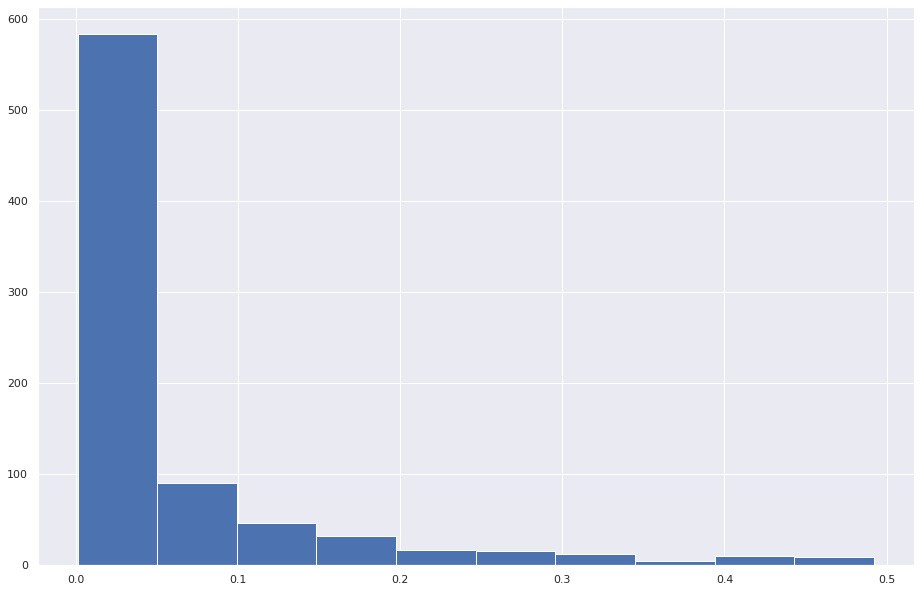

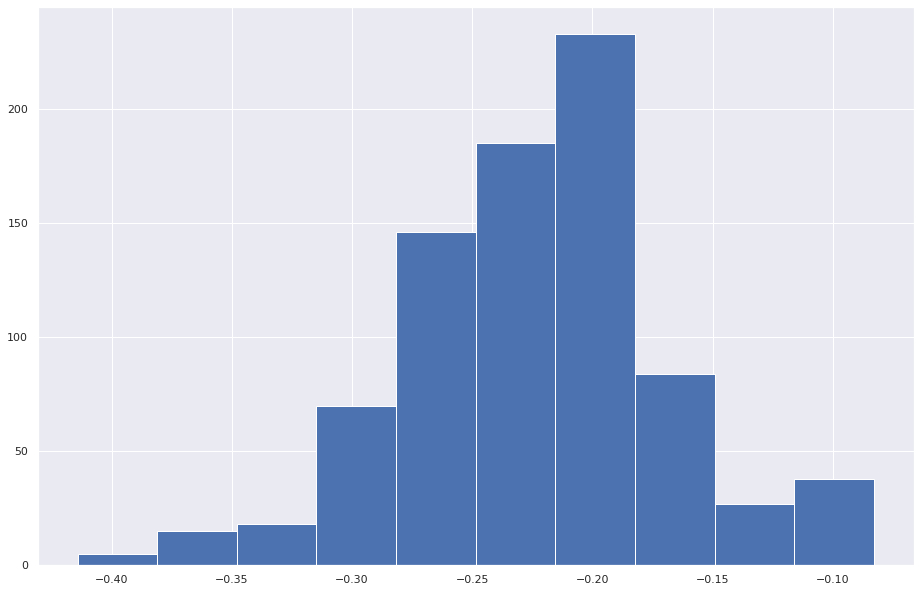

------------------Calculating mix_Rates for test models--------------------------------
sp2p, sn2p, op2p, on2p  [0.91009237] [6.08235905e-11] [1.] [0.12065495]
using random based selection of individuals for self 


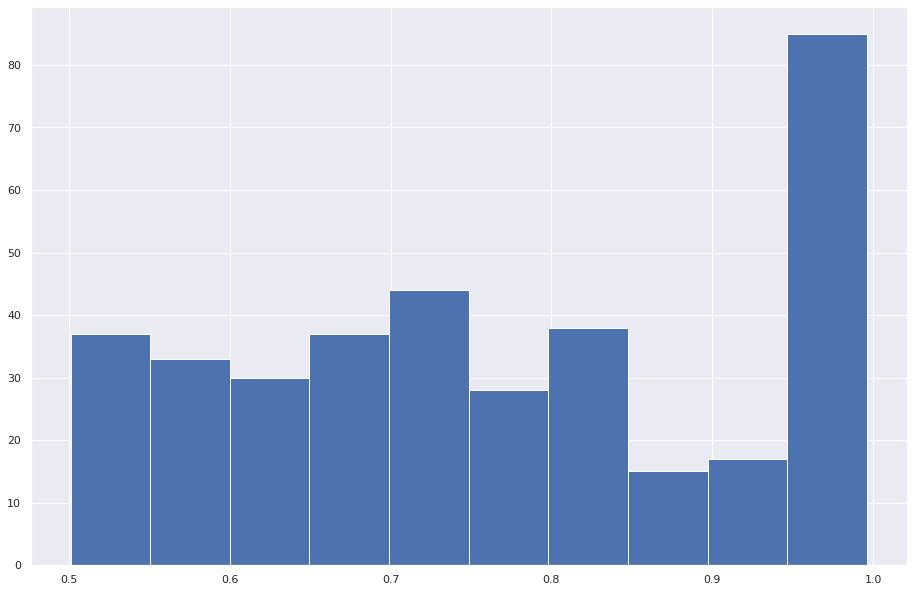

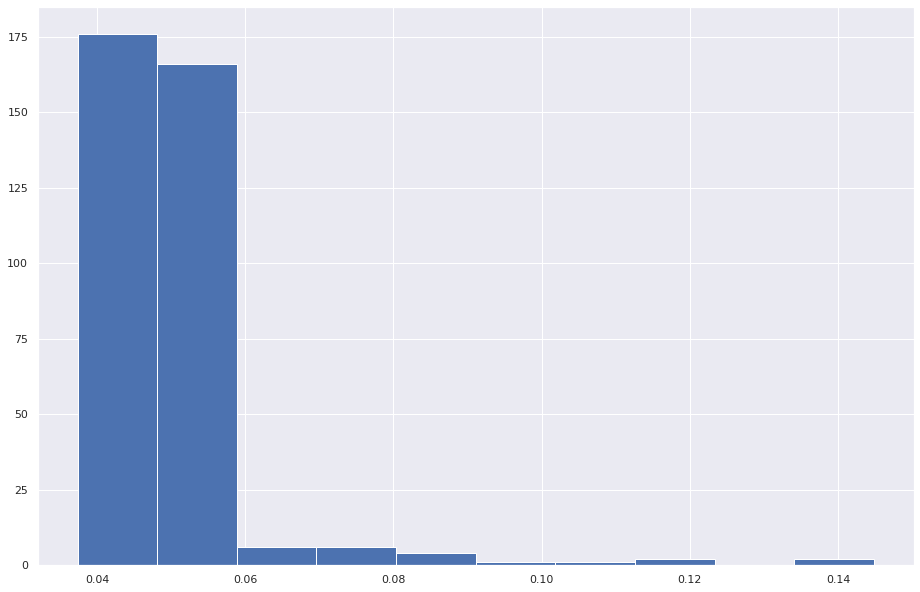

using  random selection of individuals for other 


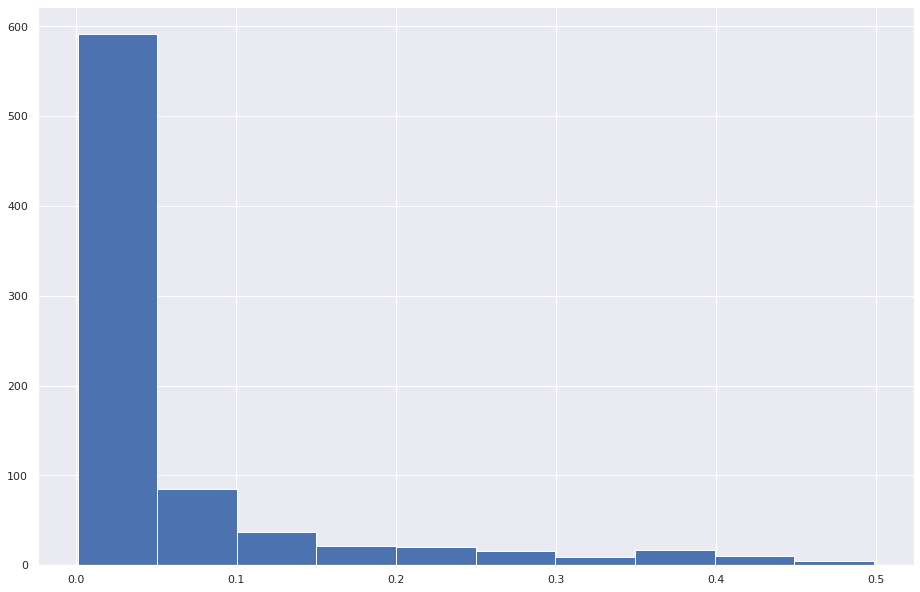

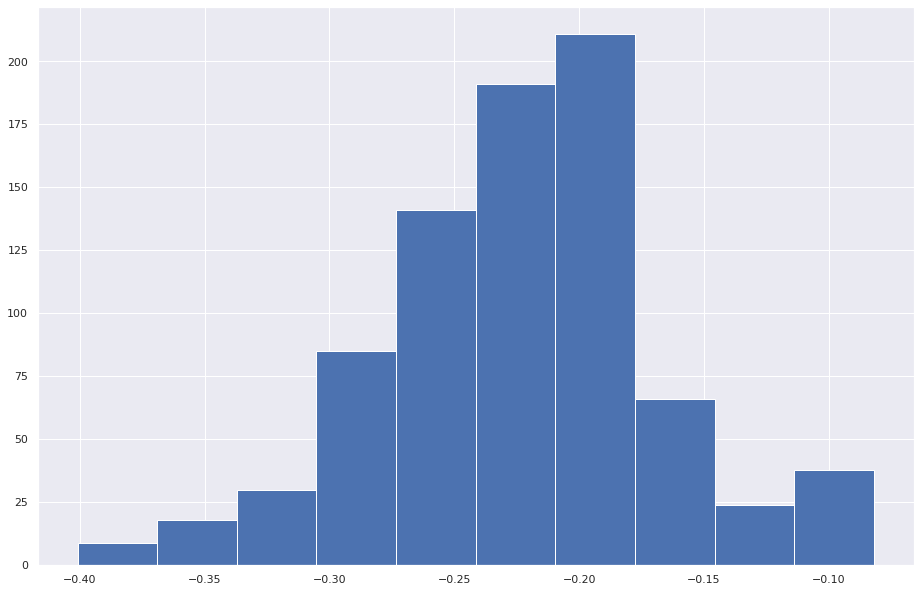

Original group 0 model:
Accuracy:	0.839
F.P. cost:	0.165
F.N. cost:	0.366
Base rate:	0.317
Avg. score:	0.314

Original group 1 model:
Accuracy:	0.934
F.P. cost:	0.061
F.N. cost:	0.444
Base rate:	0.117
Avg. score:	0.119

Equalized odds group 0 model:
Accuracy:	0.825
F.P. cost:	0.163
F.N. cost:	0.403
Base rate:	0.317
Avg. score:	0.301

Equalized odds group 1 model:
Accuracy:	0.833
F.P. cost:	0.169
F.N. cost:	0.423
Base rate:	0.117
Avg. score:	0.216



In [125]:
_, _, mix_rates_eq = Model.eq_odds(group_0_val_model, group_1_val_model)

print("------------------Calculating mix_Rates for test models--------------------------------")
# Apply the mixing rates to the test models
eq_odds_group_0_test_model, eq_odds_group_1_test_model = Model.eq_odds(group_0_test_model,
                                                                     group_1_test_model, False,
                                                                     mix_rates_eq)

# Print results on test model
print('Original group 0 model:\n%s\n' % repr(group_0_test_model))
print('Original group 1 model:\n%s\n' % repr(group_1_test_model))

print('Equalized odds group 0 model:\n%s\n' % repr(eq_odds_group_0_test_model))
print('Equalized odds group 1 model:\n%s\n' % repr(eq_odds_group_1_test_model))

sp2p, sn2p, op2p, on2p  [0.91009237] [6.08235905e-11] [1.] [0.12065495]
using SHAP based selection of individuals for self 


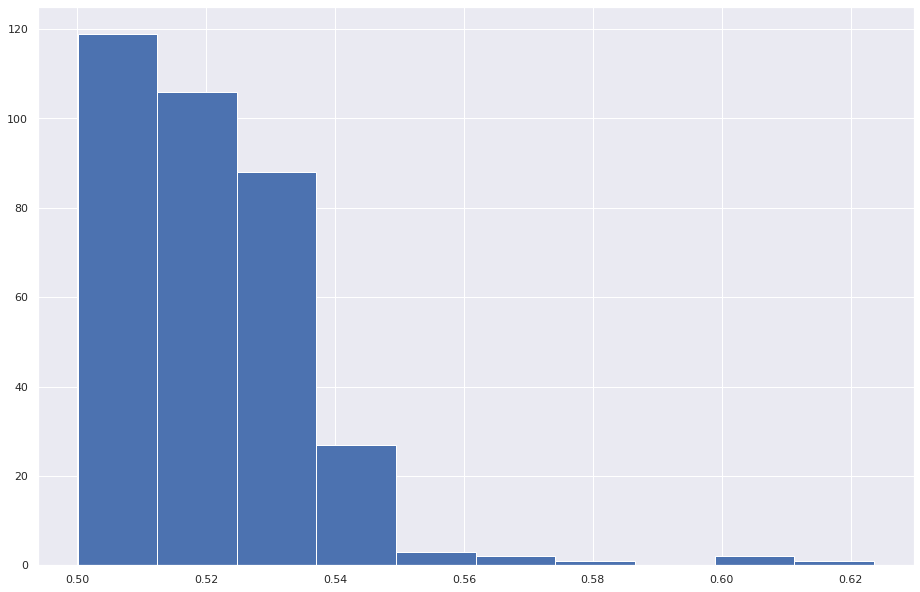

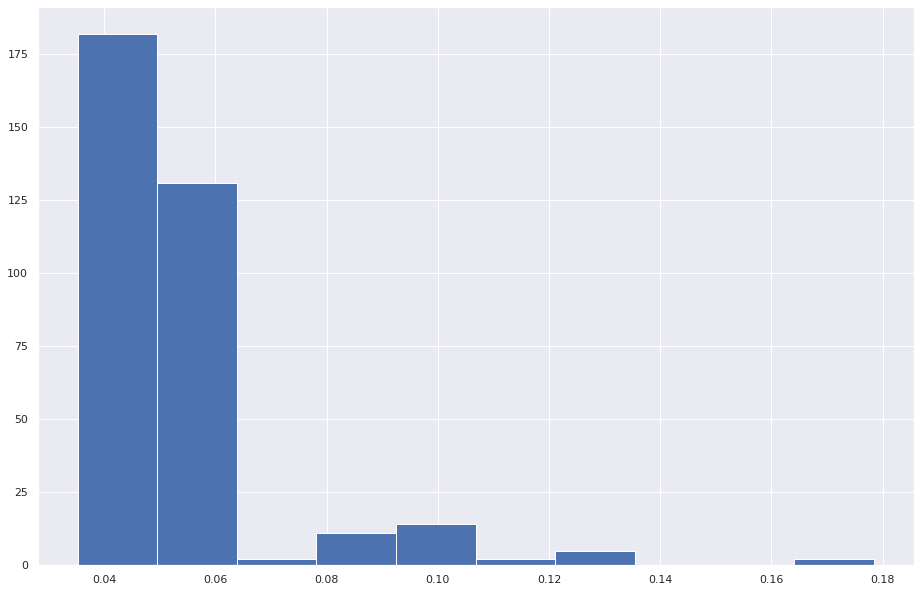

using SHAP based selection of individuals for other 


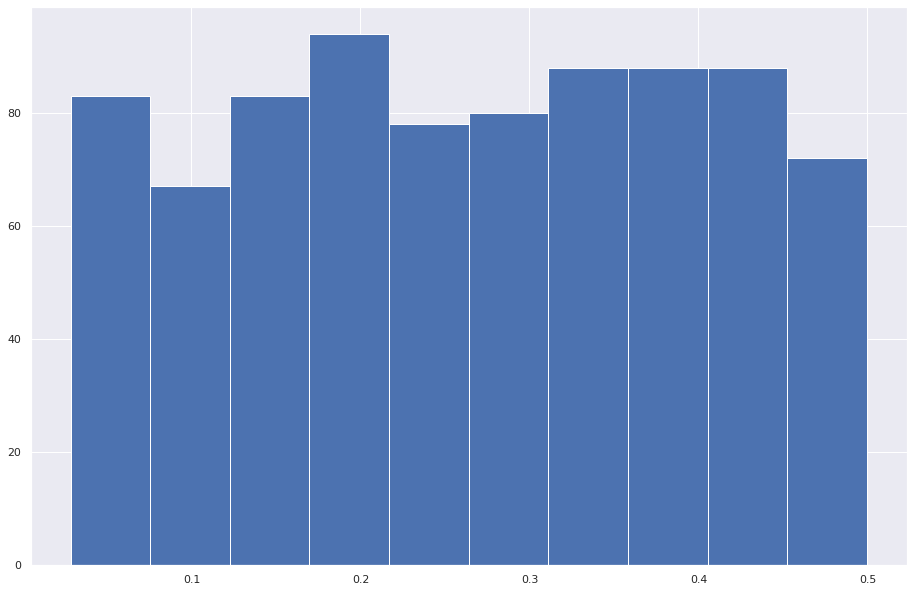

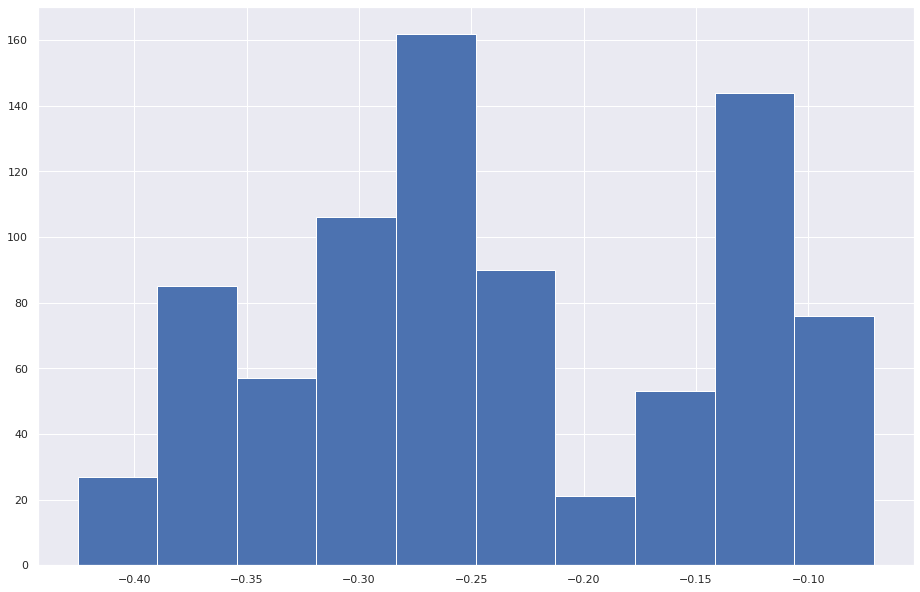

------------------Calculating mix_Rates for test models--------------------------------
[[9.10092371e-01]
 [6.08235905e-11]
 [9.99999999e-01]
 [1.20654950e-01]]
sp2p, sn2p, op2p, on2p  [0.91009237] [6.08235905e-11] [1.] [0.12065495]
using SHAP based selection of individuals for self 


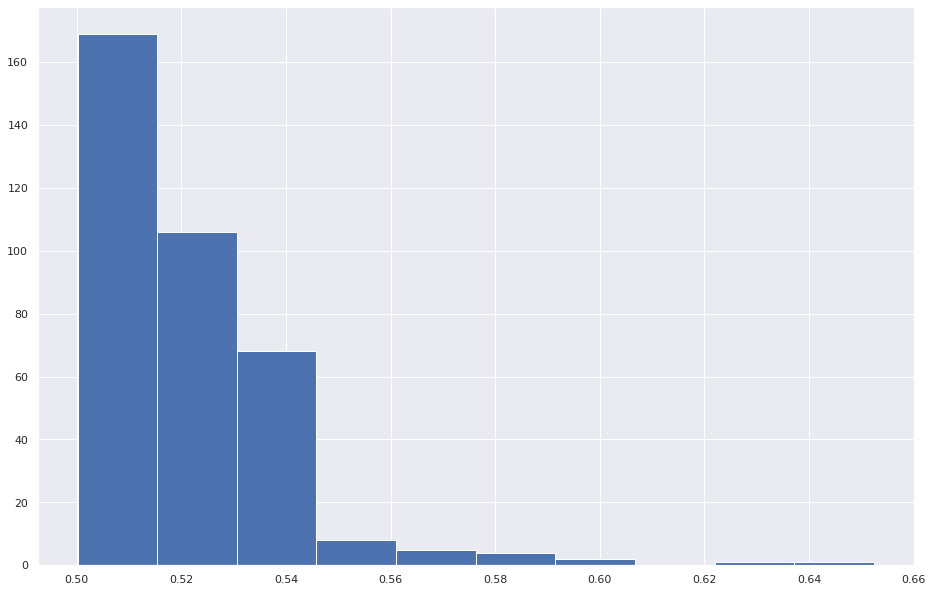

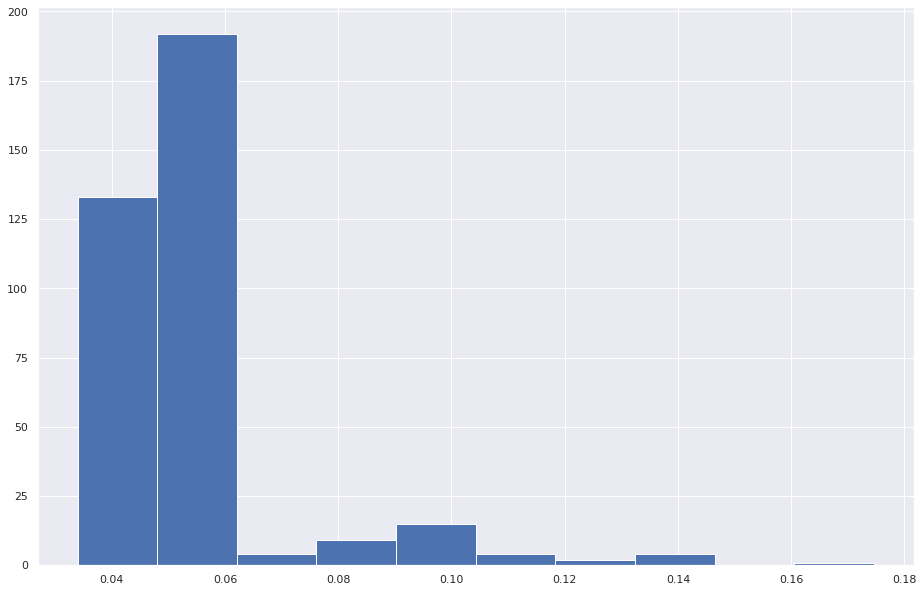

using SHAP based selection of individuals for other 


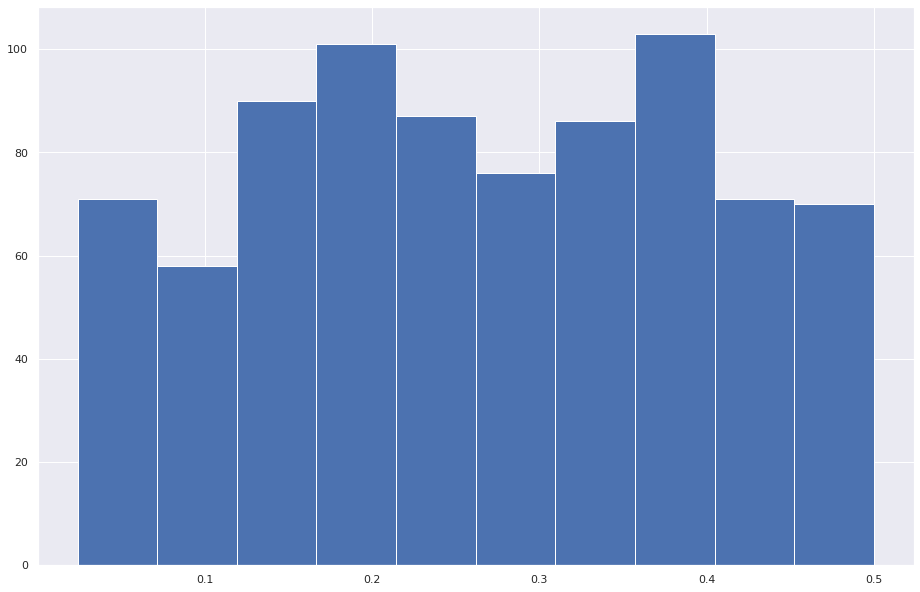

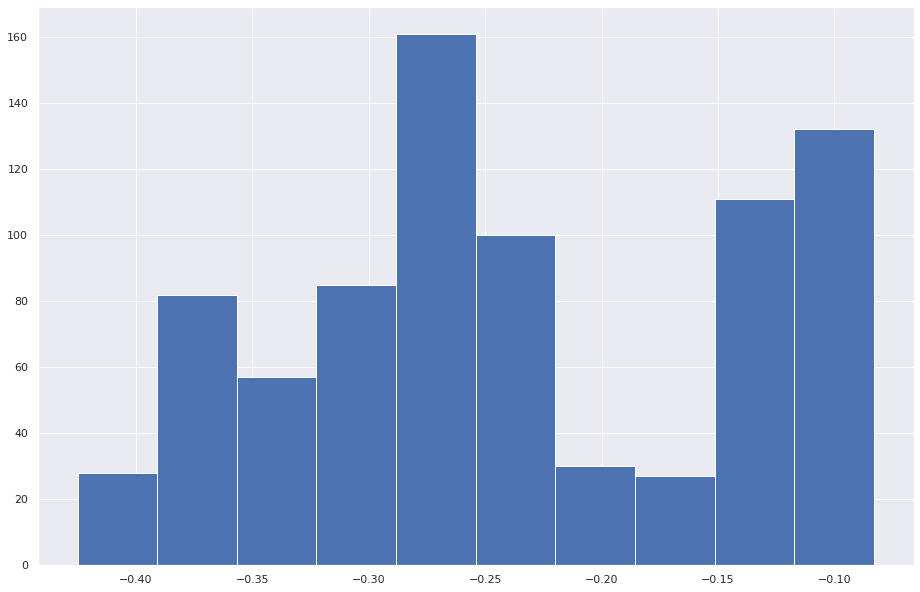

Original group 0 model:
Accuracy:	0.839
F.P. cost:	0.165
F.N. cost:	0.366
Base rate:	0.317
Avg. score:	0.314

Original group 1 model:
Accuracy:	0.934
F.P. cost:	0.061
F.N. cost:	0.444
Base rate:	0.117
Avg. score:	0.119

Equalized odds group 0 model:
Accuracy:	0.835
F.P. cost:	0.164
F.N. cost:	0.368
Base rate:	0.317
Avg. score:	0.313

Equalized odds group 1 model:
Accuracy:	0.885
F.P. cost:	0.108
F.N. cost:	0.355
Base rate:	0.117
Avg. score:	0.171



In [126]:
_, _, mix_rates_eq = Model.eq_odds(group_0_val_model, group_1_val_model, True)

print("------------------Calculating mix_Rates for test models--------------------------------")
# Apply the mixing rates to the test models
print(mix_rates_eq)
eq_odds_group_0_test_model, eq_odds_group_1_test_model = Model.eq_odds(group_0_test_model,
                                                                     group_1_test_model, True,
                                                                     mix_rates_eq)

# Print results on test model
print('Original group 0 model:\n%s\n' % repr(group_0_test_model))
print('Original group 1 model:\n%s\n' % repr(group_1_test_model))

print('Equalized odds group 0 model:\n%s\n' % repr(eq_odds_group_0_test_model))
print('Equalized odds group 1 model:\n%s\n' % repr(eq_odds_group_1_test_model))

# Calibrated Equalized Odds

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The mix_rates are  0 1.4008571970712445
Number of people with equal predictions in self  15243
Changing Other Model--------------- for other mix rate  1.4008571970712445


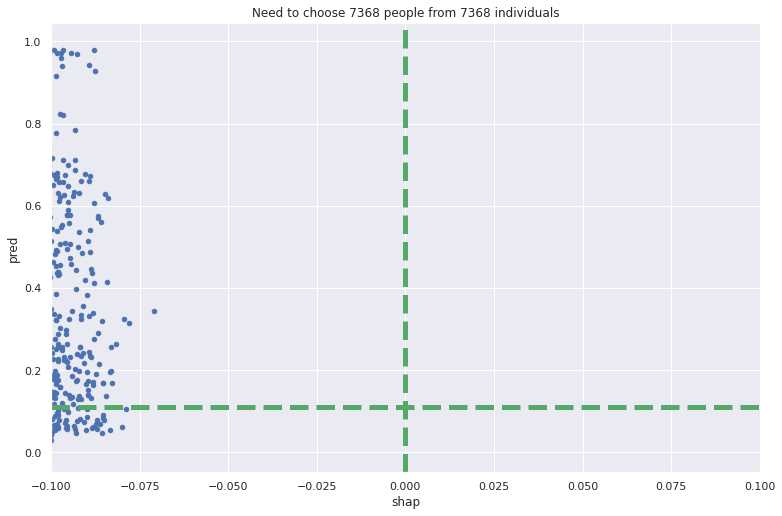

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



---------------Calculated Mix Rates and Applying to test models-----------

Number of people with equal predictions in self  15284
Changing Other Model--------------- for other mix rate  0.2


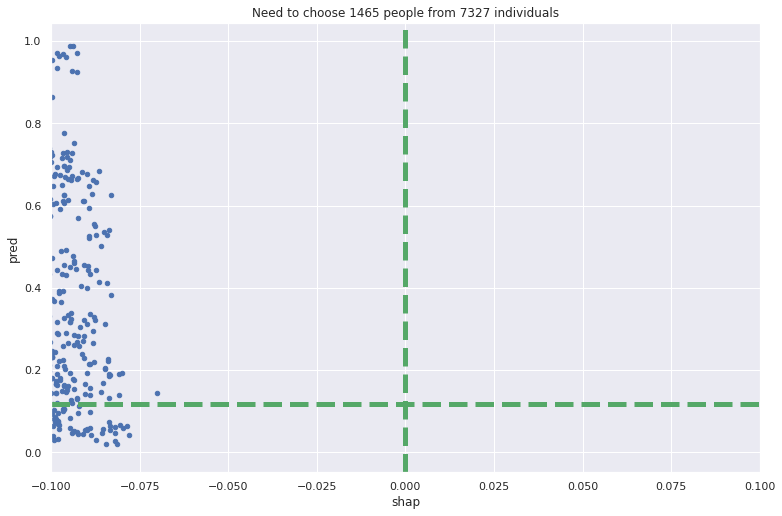


Original group 0 model:
Accuracy:	0.839
F.P. cost:	0.165
F.N. cost:	0.366
Base rate:	0.317
Avg. score:	0.314

Original group 1 model:
Accuracy:	0.934
F.P. cost:	0.061
F.N. cost:	0.444
Base rate:	0.117
Avg. score:	0.119

Randomized Calibrated Equalized odds group 0 model:
Accuracy:	0.839
F.P. cost:	0.165
F.N. cost:	0.366
Base rate:	0.317
Avg. score:	0.314

Randomized Calibrated Equalized odds group 1 model:
Accuracy:	0.922
F.P. cost:	0.072
F.N. cost:	0.546
Base rate:	0.117
Avg. score:	0.117



In [155]:
# Find mixing rates for equalized odds models
_, _, mix_rates = Model.calib_eq_odds(group_0_val_model, group_1_val_model, fp_rate, fn_rate)

# Apply the mixing rates to the test models
mix_rates = (0, 0.2)
print()
print("---------------Calculated Mix Rates and Applying to test models-----------")
print()
calib_eq_odds_group_0_test_model, calib_eq_odds_group_1_test_model = Model.calib_eq_odds(group_0_test_model,
                                                                                         group_1_test_model,
                                                                                         fp_rate, fn_rate,False,
                                                                                         mix_rates)




# Print results on test model

print()
print('Original group 0 model:\n%s\n' % repr(group_0_test_model))
print('Original group 1 model:\n%s\n' % repr(group_1_test_model))
print('Randomized Calibrated Equalized odds group 0 model:\n%s\n' % repr(calib_eq_odds_group_0_test_model))
print('Randomized Calibrated Equalized odds group 1 model:\n%s\n' % repr(calib_eq_odds_group_1_test_model))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The mix_rates are  0 1.4008571970712445
In SHAP Method Number of people changed 0 and total number 15243 
Number of people with equal predictions in self  15243
In SHAP Method Number of people changed 10321 and total number 7368 
Redistributing Predictions for Dis Advantaged Group
Number of people in each quadrant  0 1644 5724 0
10321
People taken from Quadrant 1 and 3  5724
ID 's left to take  Adfter Quadrant 1 and 3  4597
Number of ids changed in the end  1644
Changing Other Model--------------- for other mix rate  1.4008571970712445


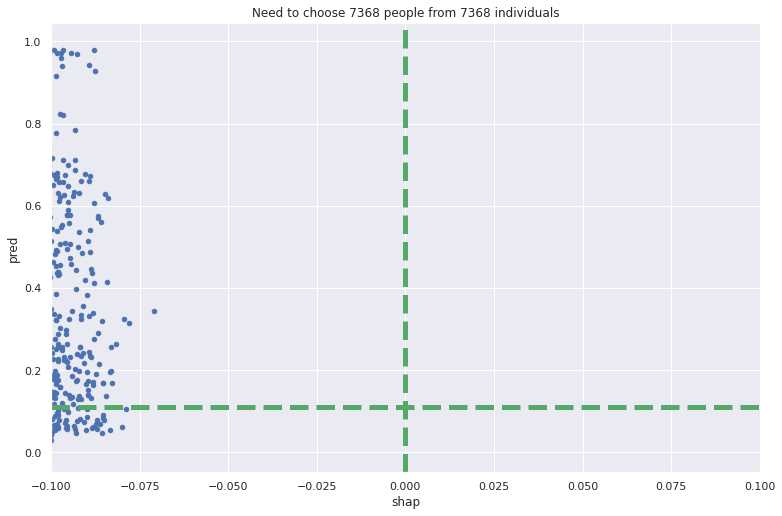

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



---------------Calculated Mix Rates and Applying to test models-----------

In SHAP Method Number of people changed 0 and total number 15284 
Number of people with equal predictions in self  15284
In SHAP Method Number of people changed 1465 and total number 7327 
Redistributing Predictions for Dis Advantaged Group
Number of people in each quadrant  0 1630 5697 0
1465
People taken from Quadrant 1 and 3  1465
ID 's left to take  Adfter Quadrant 1 and 3  0
Number of ids changed in the end  0
Changing Other Model--------------- for other mix rate  0.2


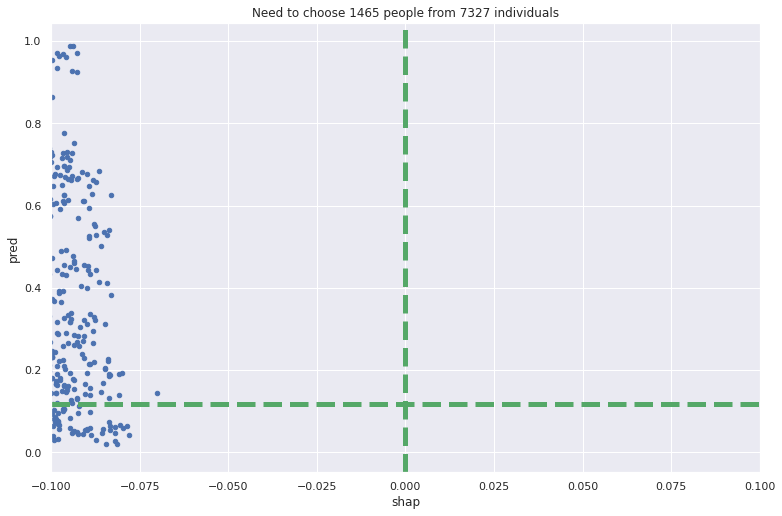


Original group 0 model:
Accuracy:	0.839
F.P. cost:	0.165
F.N. cost:	0.366
Base rate:	0.317
Avg. score:	0.314

Original group 1 model:
Accuracy:	0.934
F.P. cost:	0.061
F.N. cost:	0.444
Base rate:	0.117
Avg. score:	0.119

SHAP Fairness Calibrated Equalized odds group 0 model:
Accuracy:	0.839
F.P. cost:	0.165
F.N. cost:	0.366
Base rate:	0.317
Avg. score:	0.314

SHAP Fairness Calibrated Equalized odds group 1 model:
Accuracy:	0.934
F.P. cost:	0.078
F.N. cost:	0.442
Base rate:	0.117
Avg. score:	0.134



In [150]:

_, _, mix_rates = Model.calib_eq_odds(group_0_val_model, group_1_val_model, fp_rate, fn_rate, True)


print()
print("---------------Calculated Mix Rates and Applying to test models-----------")
print()
 
calib_eq_odds_group_0_test_model_shap, calib_eq_odds_group_1_test_model_shap = Model.calib_eq_odds(group_0_test_model,
                                                                                         group_1_test_model,
                                                                                         fp_rate, fn_rate,True,
                                                                                         mix_rates)




# Print results on test model
print()
print('Original group 0 model:\n%s\n' % repr(group_0_test_model))
print('Original group 1 model:\n%s\n' % repr(group_1_test_model))
print('SHAP Fairness Calibrated Equalized odds group 0 model:\n%s\n' % repr(calib_eq_odds_group_0_test_model_shap))
print('SHAP Fairness Calibrated Equalized odds group 1 model:\n%s\n' % repr(calib_eq_odds_group_1_test_model_shap))

In [129]:
#Hack
data_final['pred'] = pred

In [151]:
shap_df = pd.DataFrame(shap_values, columns = X.columns)
shap_df.reset_index(drop=True, inplace=True) #for some reason needed to add these to make it work, maybe because i skipped a cell from earlier where they do this
data_final.reset_index(drop=True, inplace=True)
shap_changed_ids = calib_eq_odds_group_1_test_model_shap.get_changed_id()
print(shap_changed_ids)

shap_shap = shap_df.loc[shap_changed_ids, 'female']
shap_pred = data_final.loc[shap_changed_ids, 'pred']

randomized_changed_ids =  calib_eq_odds_group_1_test_model.get_changed_id()
random_pred = data_final.loc[randomized_changed_ids, 'pred']
random_shap = shap_df.loc[randomized_changed_ids, 'female']


base_rate =  calib_eq_odds_group_1_test_model_shap.base_rate()

common_ids = set(shap_changed_ids).intersection(set(randomized_changed_ids))
print(common_ids)
print("The lenght of the unique ids in shap is %d" % len(np.unique(shap_changed_ids)))
print("The lenght of the unique ids in randmoized is %d" % len(np.unique(randomized_changed_ids)))
print("The lenght of the unique ids in common to shap and random is %d" % len(np.unique(list(common_ids))))

shap_changed_data =  data_final.loc[shap_changed_ids, X.columns.values.tolist() + ['pred']]
randomized_changed_data =  data_final.loc[randomized_changed_ids, X.columns.values.tolist() + ['pred']]

print("The lenght of the shap_shap list is %d" % len(shap_shap))
print( len(shap_shap))



[7413, 9932, 25063, 24066, 43581, 9737, 33498, 26053, 34119, 24538, 44387, 22682, 11797, 37824, 26606, 32744, 37814, 26626, 1607, 33735, 20737, 13851, 41874, 25950, 34149, 28342, 13577, 17194, 44265, 37121, 37831, 5339, 17557, 28153, 6656, 6266, 2025, 36185, 31729, 14834, 41342, 12708, 32548, 20952, 26452, 23147, 19035, 18033, 21597, 23283, 21313, 31525, 31192, 4521, 44651, 8265, 12473, 30060, 26891, 25647, 16236, 8723, 37673, 26039, 27738, 32809, 43207, 34900, 22982, 44089, 33419, 1255, 16423, 11356, 16340, 32756, 42535, 2783, 41830, 33560, 39456, 15292, 22630, 25430, 35830, 4690, 40844, 20624, 11429, 43434, 7647, 32820, 36118, 17243, 34137, 28967, 24815, 25201, 44822, 16944, 27854, 3711, 16113, 23921, 2562, 44814, 8264, 34904, 33350, 1294, 10775, 28864, 2723, 31116, 38808, 1904, 42763, 31370, 22522, 8019, 15796, 39000, 2490, 10049, 17840, 32074, 18083, 17618, 21377, 40905, 36070, 42450, 32563, 12755, 30519, 9957, 5297, 34458, 12292, 6812, 7735, 36162, 24613, 25256, 7524, 9061, 9743, 

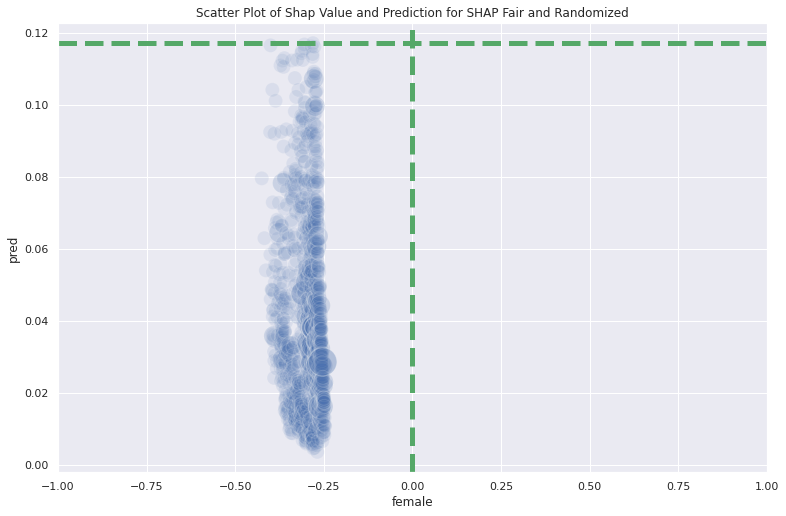

In [152]:
plt.figure()
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(15.7,10.27)})
weights_shap = [200*i for i in Counter(shap_shap).values() for j in range(i)]
weights_random = [200*i for i in Counter(random_shap).values() for j in range(i)]
sns.scatterplot(shap_shap, shap_pred, color='b',alpha=0.1, s = weights_shap)
#sns.scatterplot(random_shap, random_pred, weights_random, color = 'r', s = weights_random)
plt.xlim([-1,1])
plt.title('Scatter Plot of Shap Value and Prediction for SHAP Fair and Randomized')
plt.axhline(y=base_rate, color='g', linestyle='--', linewidth = 5)
plt.axvline(x=0, color='g', linestyle='--', linewidth = 5)

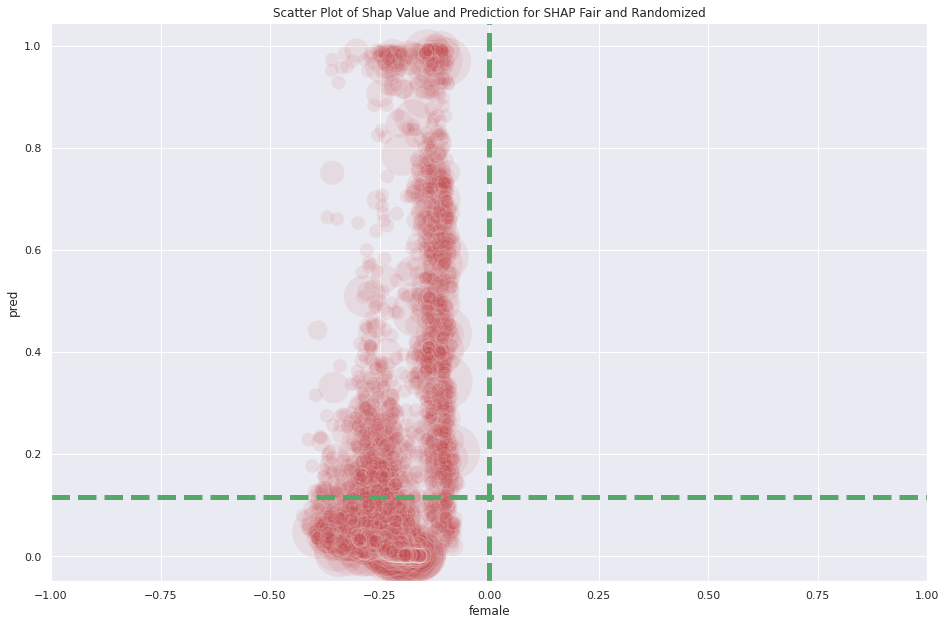

In [153]:
plt.figure()
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(15.7,10.27)})
weights_shap = [200*i for i in Counter(shap_shap).values() for j in range(i)]
weights_random = [200*i for i in Counter(random_shap).values() for j in range(i)]
#sns.scatterplot(shap_shap, shap_pred, color='b',alpha=0.1, s = weights_shap)
sns.scatterplot(random_shap, random_pred, color = 'r', alpha=0.1,s = weights_random)
plt.xlim([-1,1])
plt.title('Scatter Plot of Shap Value and Prediction for SHAP Fair and Randomized')
plt.axhline(y=base_rate, color='g', linestyle='--', linewidth = 5)
plt.axvline(x=0, color='g', linestyle='--', linewidth = 5)